In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import scipy.stats as stats

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.0.dev81+ga8bd4cf3 anndata==0.7.8 umap==0.5.2 numpy==1.21.6 scipy==1.7.3 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad('/Users/liupeiwen/BC/21 CC Single-cell analyses reveal key immune cell subsets associated with response to PD-L1 blockade in triple-negative breast cancer/data/cc.bc.sc.T.ann.h5ad')

In [4]:
ann = pd.read_csv('../1.Toomanycells/result/t_CD8-CXCL13_cluster.csv',
                  index_col=0,header=0,sep=',',
                 usecols=['cell','cluster'])

In [5]:
for i in ann.index:
    if ann.loc[i,'cluster']==16:
        ann.loc[i,'divide']='case'
    else:
        ann.loc[i,'divide']='control'

In [6]:
del ann['cluster']

In [7]:
adata.obs = adata.obs.join(ann)

In [8]:
for i in adata.obs.index:
    if (adata.obs.loc[i,'Sub_Cluster']=='t_CD8-CXCL13') & (adata.obs.loc[i,'divide']=='case'):
        adata.obs.loc[i,'cell type'] = 't_CD8-CXCL13-case'
    elif (adata.obs.loc[i,'Sub_Cluster']=='t_CD8-CXCL13') & (adata.obs.loc[i,'divide']=='control'):
        adata.obs.loc[i,'cell type'] = 't_CD8-CXCL13-control'
    else:
        adata.obs.loc[i,'cell type'] = adata.obs.loc[i, 'Sub_Cluster']

In [9]:
sc.pp.normalize_total(adata,target_sum=1e6)

normalizing counts per cell
    finished (0:00:01)


In [10]:
sc.pp.log1p(adata)

In [11]:
ligand_receptor = pd.read_csv('/Users/liupeiwen/NicheNet/ligand_receptor_pairs.csv',header=0)

In [12]:
receptor = pd.unique(ligand_receptor['to'])
ligand = pd.unique(ligand_receptor['from'])

In [13]:
adata_lr = adata[:,(adata.var_names.isin(receptor)) | (adata.var_names.isin(ligand))]

In [14]:
case = adata_lr[adata_lr.obs['cell type'] == 't_CD8-CXCL13-case']

In [15]:
control = adata_lr[adata_lr.obs['cell type'] == 't_CD8-CXCL13-control']

# E2F3

In [18]:
E2F3_case = pd.read_csv('./result/E2F3_top10_Receptor_mean_expr_regscore.csv')

In [19]:
E2F3_case.index = E2F3_case['receptor']

In [20]:
E2F3_con = pd.read_csv('./result/E2F3_top10_Receptor_mean_expr_regscore.csv')

In [21]:
E2F3_con.index = E2F3_con['receptor']

In [22]:
for i in E2F3_case['receptor'] :
    E2F3_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    E2F3_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [23]:
for i in E2F3_con['receptor'] :
    E2F3_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    E2F3_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [24]:
E2F3_case['group'] = 'case'

In [25]:
E2F3_con['group'] = 'control'

In [26]:
E2F3_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
CHEK2             0.003627    CHEK2         0.072315        0.013319  case
IL1RL1            0.003357   IL1RL1         0.000000        0.000000  case
SMYD2             0.001893    SMYD2         0.395275        0.069367  case
CHEK1             0.001745    CHEK1         0.124137        0.022752  case
RRM2              0.000596     RRM2         0.108498        0.019978  case
DDAH2             0.000362    DDAH2         0.436987        0.076582  case
MDM2              0.000339     MDM2         0.696491        0.118757  case
CDK6              0.000329     CDK6         0.645615        0.109878  case
PI4K2A            0.000234   PI4K2A         0.231987        0.039956  case
CDK4              0.000197     CDK4         0.645697        0.114872  case

In [28]:
E2F3_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
CHEK2             0.003627    CHEK2         0.046506        0.007773  control
IL1RL1            0.003357   IL1RL1         0.001540        0.000278  control
SMYD2             0.001893    SMYD2         0.284065        0.046086  control
CHEK1             0.001745    CHEK1         0.069925        0.011660  control
RRM2              0.000596     RRM2         0.050794        0.008606  control
DDAH2             0.000362    DDAH2         0.268838        0.043865  control
MDM2              0.000339     MDM2         0.385444        0.062743  control
CDK6              0.000329     CDK6         0.359249        0.058023  control
PI4K2A            0.000234   PI4K2A         0.077471        0.012771  control
CDK4              0.000197     CDK4         0.436644        0.071349  control

In [29]:
E2F3 = E2F3_case.append(E2F3_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/257219580.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  E2F3 = E2F3_case.append(E2F3_con,ignore_index=True)


In [30]:
E2F3

regulatory_score receptor  mean_expression  detection_rate    group
0           0.003627    CHEK2         0.072315        0.013319     case
1           0.003357   IL1RL1         0.000000        0.000000     case
2           0.001893    SMYD2         0.395275        0.069367     case
3           0.001745    CHEK1         0.124137        0.022752     case
4           0.000596     RRM2         0.108498        0.019978     case
5           0.000362    DDAH2         0.436987        0.076582     case
6           0.000339     MDM2         0.696491        0.118757     case
7           0.000329     CDK6         0.645615        0.109878     case
8           0.000234   PI4K2A         0.231987        0.039956     case
9           0.000197     CDK4         0.645697        0.114872     case
10          0.003627    CHEK2         0.046506        0.007773  control
11          0.003357   IL1RL1         0.001540        0.000278  control
12          0.001893    SMYD2         0.284065        0.046086  control
13          0.001745    CHEK1         0.069925        0.011660  control
14          0.000596     RRM2         0.050794        0.008606  control
15          0.000362    DDAH2         0.268838        0.043865  control
16          0.000339     MDM2         0.385444        0.062743  control
17          0.000329     CDK6         0.359249        0.058023  control
18          0.000234   PI4K2A         0.077471        0.012771  control
19          0.000197     CDK4         0.436644        0.071349  control

In [31]:
for i in E2F3.index:
#     if E2F3.loc[i,'receptor'] != 'NOX1':
    rec = E2F3.loc[i,'receptor']
    E2F3.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [32]:
E2F3

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.003627    CHEK2         0.072315        0.013319     case   
1           0.003357   IL1RL1         0.000000        0.000000     case   
2           0.001893    SMYD2         0.395275        0.069367     case   
3           0.001745    CHEK1         0.124137        0.022752     case   
4           0.000596     RRM2         0.108498        0.019978     case   
5           0.000362    DDAH2         0.436987        0.076582     case   
6           0.000339     MDM2         0.696491        0.118757     case   
7           0.000329     CDK6         0.645615        0.109878     case   
8           0.000234   PI4K2A         0.231987        0.039956     case   
9           0.000197     CDK4         0.645697        0.114872     case   
10          0.003627    CHEK2         0.046506        0.007773  control   
11          0.003357   IL1RL1         0.001540        0.000278  control   
12          0.001893    SMYD2         0.284065        0.046086  control   
13          0.001745    CHEK1         0.069925        0.011660  control   
14          0.000596     RRM2         0.050794        0.008606  control   
15          0.000362    DDAH2         0.268838        0.043865  control   
16          0.000339     MDM2         0.385444        0.062743  control   
17          0.000329     CDK6         0.359249        0.058023  control   
18          0.000234   PI4K2A         0.077471        0.012771  control   
19          0.000197     CDK4         0.436644        0.071349  control   

    mann_whitney_u-pval  
0          2.552626e-02  
1          7.604328e-01  
2          4.442979e-04  
3          1.026322e-03  
4          1.991630e-04  
5          1.002817e-06  
6          5.812985e-12  
7          3.391902e-11  
8          7.214903e-11  
9          6.680545e-07  
10         2.552626e-02  
11         7.604328e-01  
12         4.442979e-04  
13         1.026322e-03  
14         1.991630e-04  
15         1.002817e-06  
16         5.812985e-12  
17         3.391902e-11  
18         7.214903e-11  
19         6.680545e-07

In [33]:
E2F3.to_csv('./result/E2F3_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

# FOXJ2

In [35]:
FOXJ2_case = pd.read_csv('./result/FOXJ2_top10_Receptor_mean_expr_regscore.csv')

In [36]:
FOXJ2_case.index = FOXJ2_case['receptor']

In [37]:
FOXJ2_con = pd.read_csv('./result/FOXJ2_top10_Receptor_mean_expr_regscore.csv')

In [38]:
FOXJ2_con.index = FOXJ2_con['receptor']

In [39]:
for i in FOXJ2_case['receptor'] :
    FOXJ2_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    FOXJ2_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [40]:
for i in FOXJ2_con['receptor'] :
    FOXJ2_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    FOXJ2_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [41]:
FOXJ2_case['group'] = 'case'

In [42]:
FOXJ2_con['group'] = 'control'

In [43]:
FOXJ2_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
SGK1          2.808232e-05     SGK1         0.474589        0.078246  case
RPS6KB1       2.588299e-05  RPS6KB1         0.694322        0.118757  case
PIK3C2B       8.255311e-06  PIK3C2B         0.079715        0.013873  case
APLP2         3.747113e-06    APLP2         0.761909        0.128191  case
GPR160        2.416448e-06   GPR160         0.022125        0.003885  case
CTSS          2.314512e-06     CTSS         1.408812        0.236404  case
CTSD          1.790164e-06     CTSD         0.868359        0.149279  case
CTSL          5.843693e-07     CTSL         0.087220        0.015538  case
TRPC3         0.000000e+00    TRPC3         0.013358        0.002220  case
TRPV6         0.000000e+00    TRPV6         0.000000        0.000000  case

In [44]:
FOXJ2_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
SGK1          2.808232e-05     SGK1         0.444680        0.069128  control
RPS6KB1       2.588299e-05  RPS6KB1         0.303846        0.049417  control
PIK3C2B       8.255311e-06  PIK3C2B         0.050674        0.008329  control
APLP2         3.747113e-06    APLP2         0.424143        0.068573  control
GPR160        2.416448e-06   GPR160         0.012859        0.002221  control
CTSS          2.314512e-06     CTSS         1.140084        0.182121  control
CTSD          1.790164e-06     CTSD         0.638480        0.101888  control
CTSL          5.843693e-07     CTSL         0.078928        0.013048  control
TRPC3         0.000000e+00    TRPC3         0.004817        0.000833  control
TRPV6         0.000000e+00    TRPV6         0.000000        0.000000  control

In [45]:
FOXJ2 = FOXJ2_case.append(FOXJ2_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/4087989543.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  FOXJ2 = FOXJ2_case.append(FOXJ2_con,ignore_index=True)


In [46]:
FOXJ2

regulatory_score receptor  mean_expression  detection_rate    group
0       2.808232e-05     SGK1         0.474589        0.078246     case
1       2.588299e-05  RPS6KB1         0.694322        0.118757     case
2       8.255311e-06  PIK3C2B         0.079715        0.013873     case
3       3.747113e-06    APLP2         0.761909        0.128191     case
4       2.416448e-06   GPR160         0.022125        0.003885     case
5       2.314512e-06     CTSS         1.408812        0.236404     case
6       1.790164e-06     CTSD         0.868359        0.149279     case
7       5.843693e-07     CTSL         0.087220        0.015538     case
8       0.000000e+00    TRPC3         0.013358        0.002220     case
9       0.000000e+00    TRPV6         0.000000        0.000000     case
10      2.808232e-05     SGK1         0.444680        0.069128  control
11      2.588299e-05  RPS6KB1         0.303846        0.049417  control
12      8.255311e-06  PIK3C2B         0.050674        0.008329  control
13      3.747113e-06    APLP2         0.424143        0.068573  control
14      2.416448e-06   GPR160         0.012859        0.002221  control
15      2.314512e-06     CTSS         1.140084        0.182121  control
16      1.790164e-06     CTSD         0.638480        0.101888  control
17      5.843693e-07     CTSL         0.078928        0.013048  control
18      0.000000e+00    TRPC3         0.004817        0.000833  control
19      0.000000e+00    TRPV6         0.000000        0.000000  control

In [47]:
for i in FOXJ2.index:
    if (FOXJ2.loc[i,'receptor'] != 'NOX1') & (FOXJ2.loc[i,'receptor'] != 'MOS'):
        rec = FOXJ2.loc[i,'receptor']
        FOXJ2.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [48]:
FOXJ2

regulatory_score receptor  mean_expression  detection_rate    group  \
0       2.808232e-05     SGK1         0.474589        0.078246     case   
1       2.588299e-05  RPS6KB1         0.694322        0.118757     case   
2       8.255311e-06  PIK3C2B         0.079715        0.013873     case   
3       3.747113e-06    APLP2         0.761909        0.128191     case   
4       2.416448e-06   GPR160         0.022125        0.003885     case   
5       2.314512e-06     CTSS         1.408812        0.236404     case   
6       1.790164e-06     CTSD         0.868359        0.149279     case   
7       5.843693e-07     CTSL         0.087220        0.015538     case   
8       0.000000e+00    TRPC3         0.013358        0.002220     case   
9       0.000000e+00    TRPV6         0.000000        0.000000     case   
10      2.808232e-05     SGK1         0.444680        0.069128  control   
11      2.588299e-05  RPS6KB1         0.303846        0.049417  control   
12      8.255311e-06  PIK3C2B         0.050674        0.008329  control   
13      3.747113e-06    APLP2         0.424143        0.068573  control   
14      2.416448e-06   GPR160         0.012859        0.002221  control   
15      2.314512e-06     CTSS         1.140084        0.182121  control   
16      1.790164e-06     CTSD         0.638480        0.101888  control   
17      5.843693e-07     CTSL         0.078928        0.013048  control   
18      0.000000e+00    TRPC3         0.004817        0.000833  control   
19      0.000000e+00    TRPV6         0.000000        0.000000  control   

    mann_whitney_u-pval  
0          1.611743e-01  
1          1.017324e-19  
2          2.890880e-02  
3          1.368887e-12  
4          1.367053e-01  
5          2.961148e-04  
6          7.563169e-06  
7          2.388541e-01  
8          9.061552e-02  
9          1.000000e+00  
10         1.611743e-01  
11         1.017324e-19  
12         2.890880e-02  
13         1.368887e-12  
14         1.367053e-01  
15         2.961148e-04  
16         7.563169e-06  
17         2.388541e-01  
18         9.061552e-02  
19         1.000000e+00

In [49]:
FOXJ2.to_csv('./result/FOXJ2_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [50]:
FOXJ2_lig = ligand_receptor[ligand_receptor['to'].isin(['CTSS'])]

In [51]:
FOXJ2_lig.sort_values(['to','from'])

from    to
3780   HLA-DMA  CTSS
3785   HLA-DMB  CTSS
3784   HLA-DOA  CTSS
3783   HLA-DOB  CTSS
3774  HLA-DPA1  CTSS
3776  HLA-DPB1  CTSS
3775  HLA-DQA1  CTSS
3777  HLA-DQA2  CTSS
3771  HLA-DQB1  CTSS
3772  HLA-DQB2  CTSS
3781   HLA-DRA  CTSS
3779  HLA-DRB1  CTSS
3773  HLA-DRB3  CTSS
3782  HLA-DRB4  CTSS
3778  HLA-DRB5  CTSS
5626      IFNG  CTSS
5745       TNF  CTSS

In [53]:
FOXJ2_lig1 = pd.unique(FOXJ2_lig['from'])

In [54]:
FOXJ2_lig1

array(['HLA-DQB1', 'HLA-DQB2', 'HLA-DRB3', 'HLA-DPA1', 'HLA-DQA1',
       'HLA-DPB1', 'HLA-DQA2', 'HLA-DRB5', 'HLA-DRB1', 'HLA-DMA',
       'HLA-DRA', 'HLA-DRB4', 'HLA-DOB', 'HLA-DOA', 'HLA-DMB', 'IFNG',
       'TNF'], dtype=object)

In [56]:
FOXJ2_lig1 = np.delete(FOXJ2_lig1,[2,11])

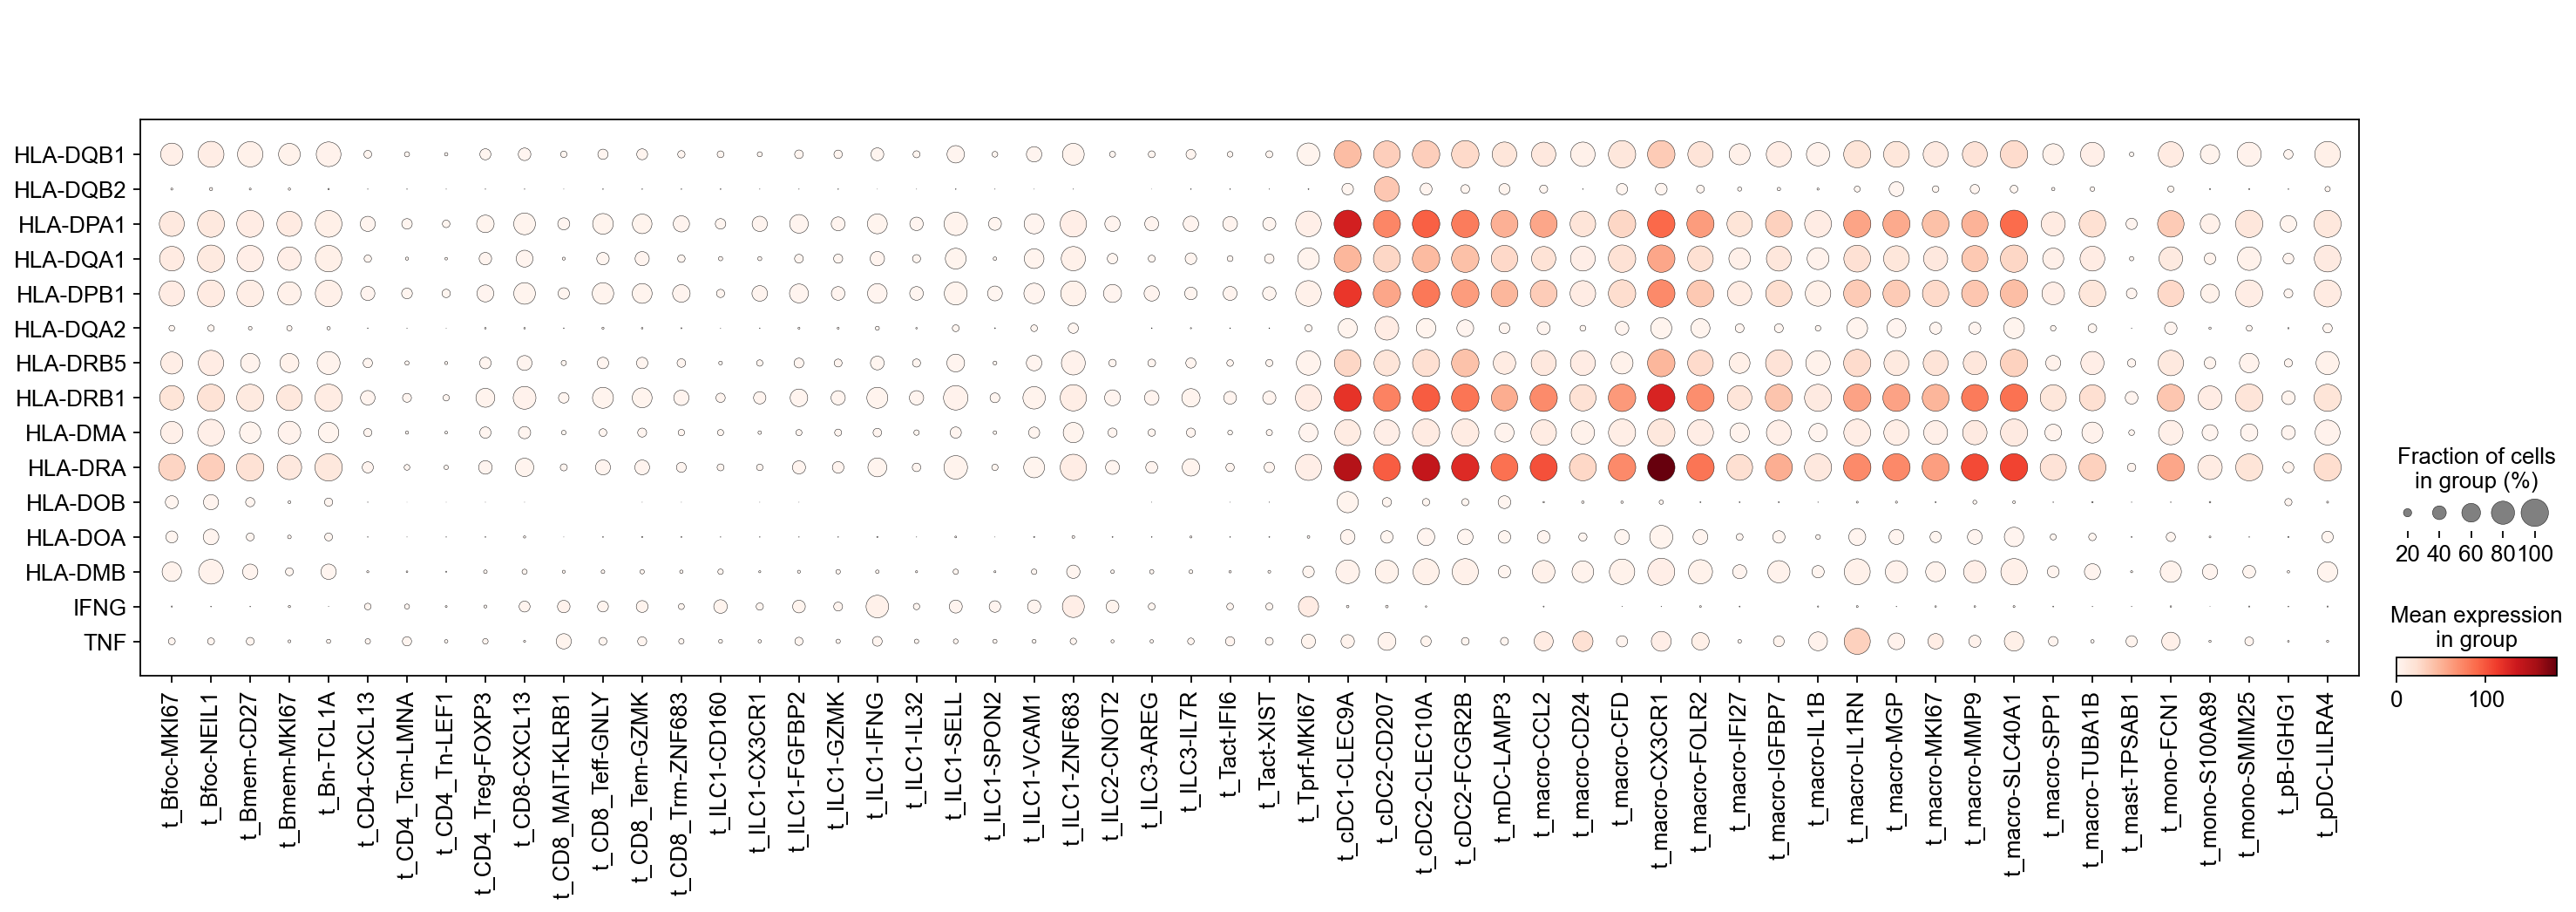

In [57]:
sc.pl.dotplot(adata, FOXJ2_lig1, 'Sub_Cluster',swap_axes=True)

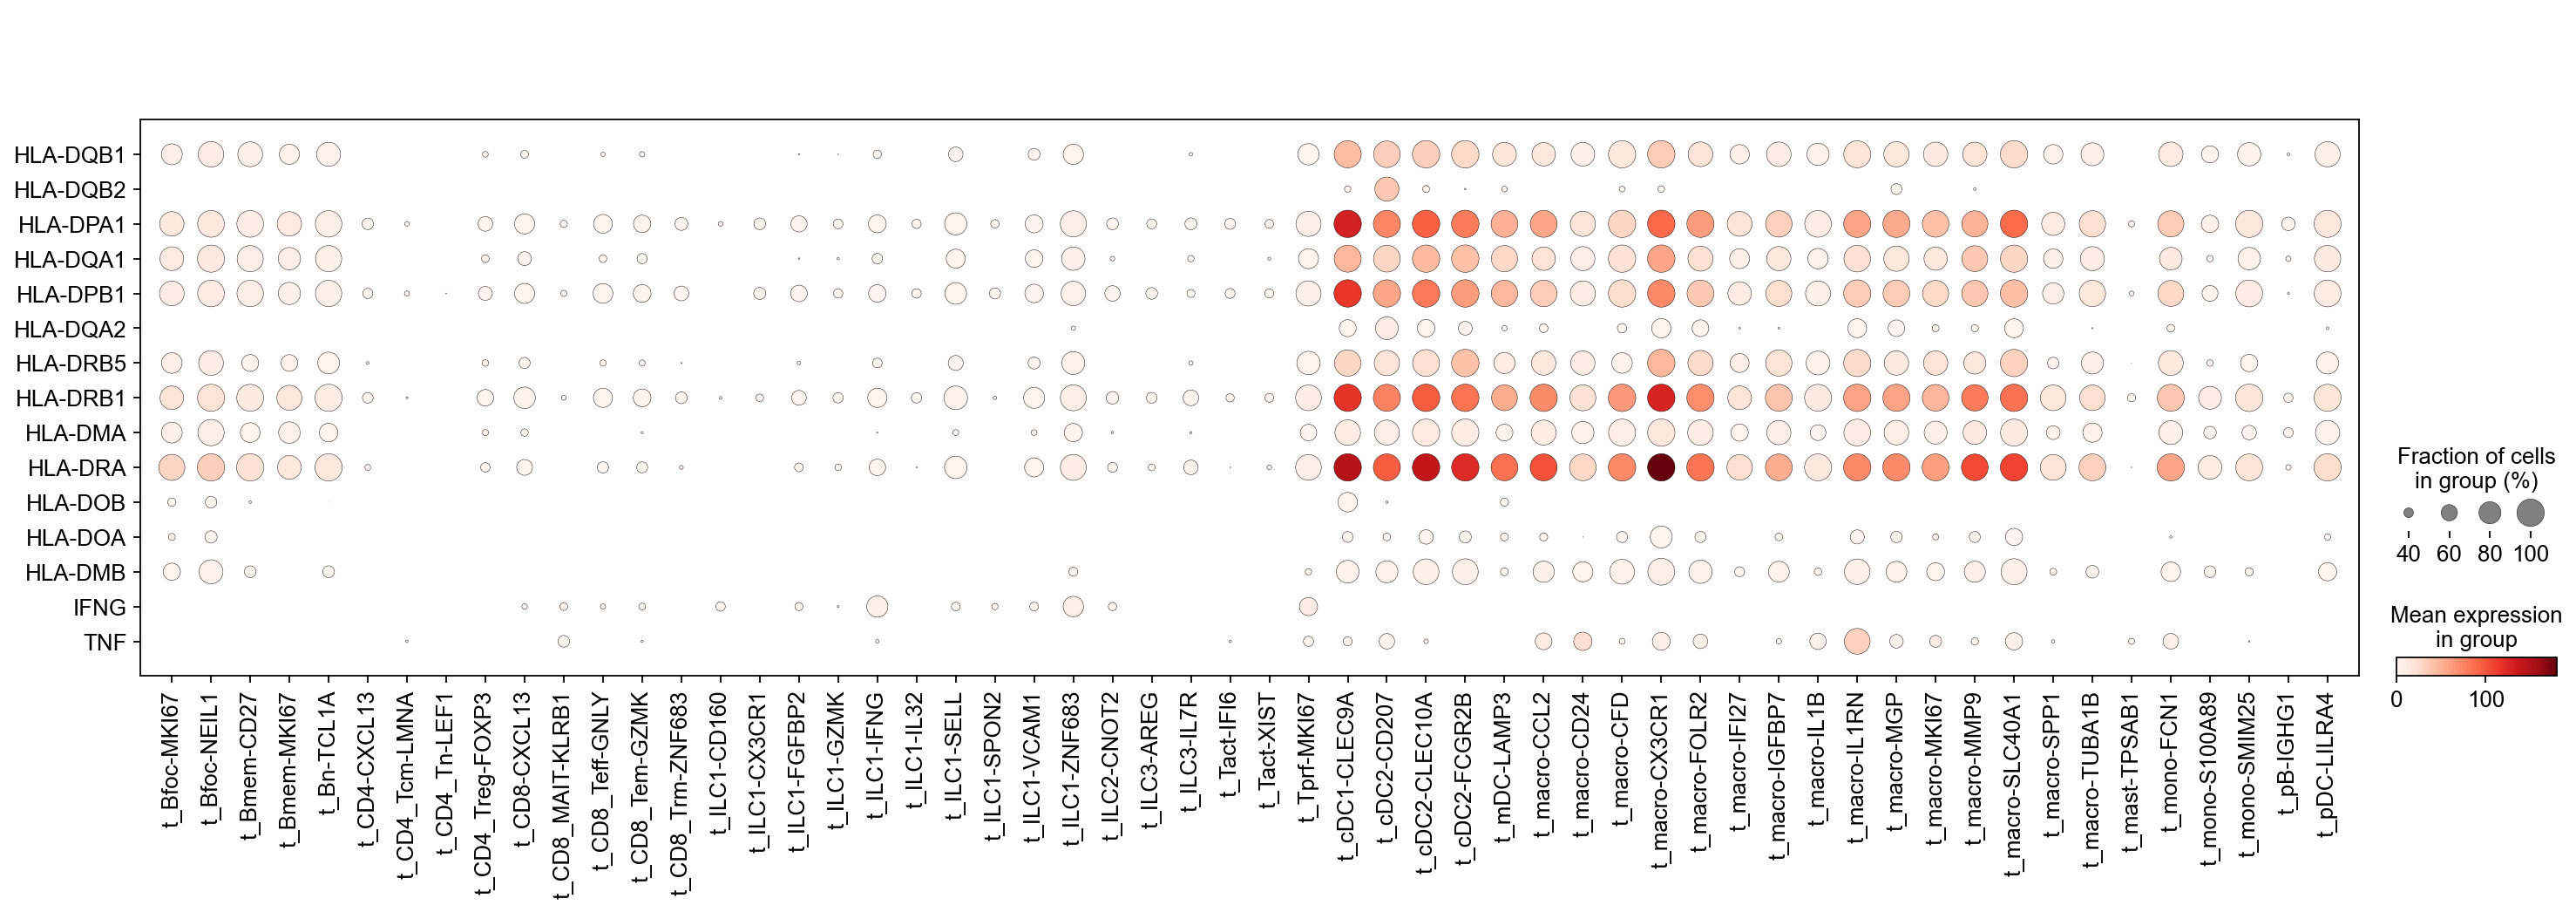

In [58]:
sc.pl.dotplot(adata, FOXJ2_lig1, 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# GABPA

In [59]:
GABPA_case = pd.read_csv('./result/GABPA_top10_Receptor_mean_expr_regscore.csv')

In [60]:
GABPA_case.index = GABPA_case['receptor']

In [61]:
GABPA_con = pd.read_csv('./result/GABPA_top10_Receptor_mean_expr_regscore.csv')

In [62]:
GABPA_con.index = GABPA_con['receptor']

In [63]:
for i in GABPA_case['receptor'] :
    GABPA_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    GABPA_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [64]:
for i in GABPA_con['receptor'] :
    GABPA_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    GABPA_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [65]:
GABPA_case['group'] = 'case'

In [66]:
GABPA_con['group'] = 'control'

In [67]:
GABPA_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
KEAP1             0.014249    KEAP1         0.551895        0.096559  case
NFE2L2            0.001240   NFE2L2         2.213949        0.365705  case
RPS6KA2           0.000163  RPS6KA2         0.010298        0.001665  case
PRKCE             0.000055    PRKCE         0.124986        0.022198  case
MAPK3             0.000054    MAPK3         0.254237        0.044395  case
CDK11A            0.000021   CDK11A         0.790183        0.133740  case
CRHR1             0.000017    CRHR1         0.000000        0.000000  case
MAP2K5            0.000016   MAP2K5         0.413343        0.071587  case
BCL6              0.000014     BCL6         0.352422        0.059378  case
FGR               0.000012      FGR         0.013246        0.002220  case

In [68]:
GABPA_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
KEAP1             0.014249    KEAP1         0.351944        0.057746  control
NFE2L2            0.001240   NFE2L2         1.408174        0.223487  control
RPS6KA2           0.000163  RPS6KA2         0.005080        0.000833  control
PRKCE             0.000055    PRKCE         0.065018        0.010550  control
MAPK3             0.000054    MAPK3         0.204268        0.033592  control
CDK11A            0.000021   CDK11A         0.540527        0.087174  control
CRHR1             0.000017    CRHR1         0.000000        0.000000  control
MAP2K5            0.000016   MAP2K5         0.208447        0.033870  control
BCL6              0.000014     BCL6         0.182092        0.029983  control
FGR               0.000012      FGR         0.016424        0.002776  control

In [69]:
GABPA = GABPA_case.append(GABPA_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/619313840.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  GABPA = GABPA_case.append(GABPA_con,ignore_index=True)


In [70]:
GABPA

regulatory_score receptor  mean_expression  detection_rate    group
0           0.014249    KEAP1         0.551895        0.096559     case
1           0.001240   NFE2L2         2.213949        0.365705     case
2           0.000163  RPS6KA2         0.010298        0.001665     case
3           0.000055    PRKCE         0.124986        0.022198     case
4           0.000054    MAPK3         0.254237        0.044395     case
5           0.000021   CDK11A         0.790183        0.133740     case
6           0.000017    CRHR1         0.000000        0.000000     case
7           0.000016   MAP2K5         0.413343        0.071587     case
8           0.000014     BCL6         0.352422        0.059378     case
9           0.000012      FGR         0.013246        0.002220     case
10          0.014249    KEAP1         0.351944        0.057746  control
11          0.001240   NFE2L2         1.408174        0.223487  control
12          0.000163  RPS6KA2         0.005080        0.000833  control
13          0.000055    PRKCE         0.065018        0.010550  control
14          0.000054    MAPK3         0.204268        0.033592  control
15          0.000021   CDK11A         0.540527        0.087174  control
16          0.000017    CRHR1         0.000000        0.000000  control
17          0.000016   MAP2K5         0.208447        0.033870  control
18          0.000014     BCL6         0.182092        0.029983  control
19          0.000012      FGR         0.016424        0.002776  control

In [71]:
for i in GABPA.index:
    rec = GABPA.loc[i,'receptor']
    GABPA.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [72]:
GABPA

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.014249    KEAP1         0.551895        0.096559     case   
1           0.001240   NFE2L2         2.213949        0.365705     case   
2           0.000163  RPS6KA2         0.010298        0.001665     case   
3           0.000055    PRKCE         0.124986        0.022198     case   
4           0.000054    MAPK3         0.254237        0.044395     case   
5           0.000021   CDK11A         0.790183        0.133740     case   
6           0.000017    CRHR1         0.000000        0.000000     case   
7           0.000016   MAP2K5         0.413343        0.071587     case   
8           0.000014     BCL6         0.352422        0.059378     case   
9           0.000012      FGR         0.013246        0.002220     case   
10          0.014249    KEAP1         0.351944        0.057746  control   
11          0.001240   NFE2L2         1.408174        0.223487  control   
12          0.000163  RPS6KA2         0.005080        0.000833  control   
13          0.000055    PRKCE         0.065018        0.010550  control   
14          0.000054    MAPK3         0.204268        0.033592  control   
15          0.000021   CDK11A         0.540527        0.087174  control   
16          0.000017    CRHR1         0.000000        0.000000  control   
17          0.000016   MAP2K5         0.208447        0.033870  control   
18          0.000014     BCL6         0.182092        0.029983  control   
19          0.000012      FGR         0.016424        0.002776  control   

    mann_whitney_u-pval  
0          3.540740e-07  
1          9.631332e-21  
2          1.933260e-01  
3          4.039291e-04  
4          2.958395e-02  
5          5.448858e-07  
6          1.000000e+00  
7          7.141589e-10  
8          1.254988e-07  
9          6.475966e-01  
10         3.540740e-07  
11         9.631332e-21  
12         1.933260e-01  
13         4.039291e-04  
14         2.958395e-02  
15         5.448858e-07  
16         1.000000e+00  
17         7.141589e-10  
18         1.254988e-07  
19         6.475966e-01

In [73]:
GABPA.to_csv('./result/GABPA_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [74]:
GABPA_lig = ligand_receptor[ligand_receptor['to'].isin(['NFE2L2'])]

In [75]:
GABPA_lig

from      to
3598    FYN  NFE2L2
3729    TNF  NFE2L2
3730  VEGFA  NFE2L2
3732  PTGS2  NFE2L2
4510  ANXA1  NFE2L2
4617   EGFR  NFE2L2
4618   CNTF  NFE2L2
4619   FGF7  NFE2L2
6105   TP53  NFE2L2

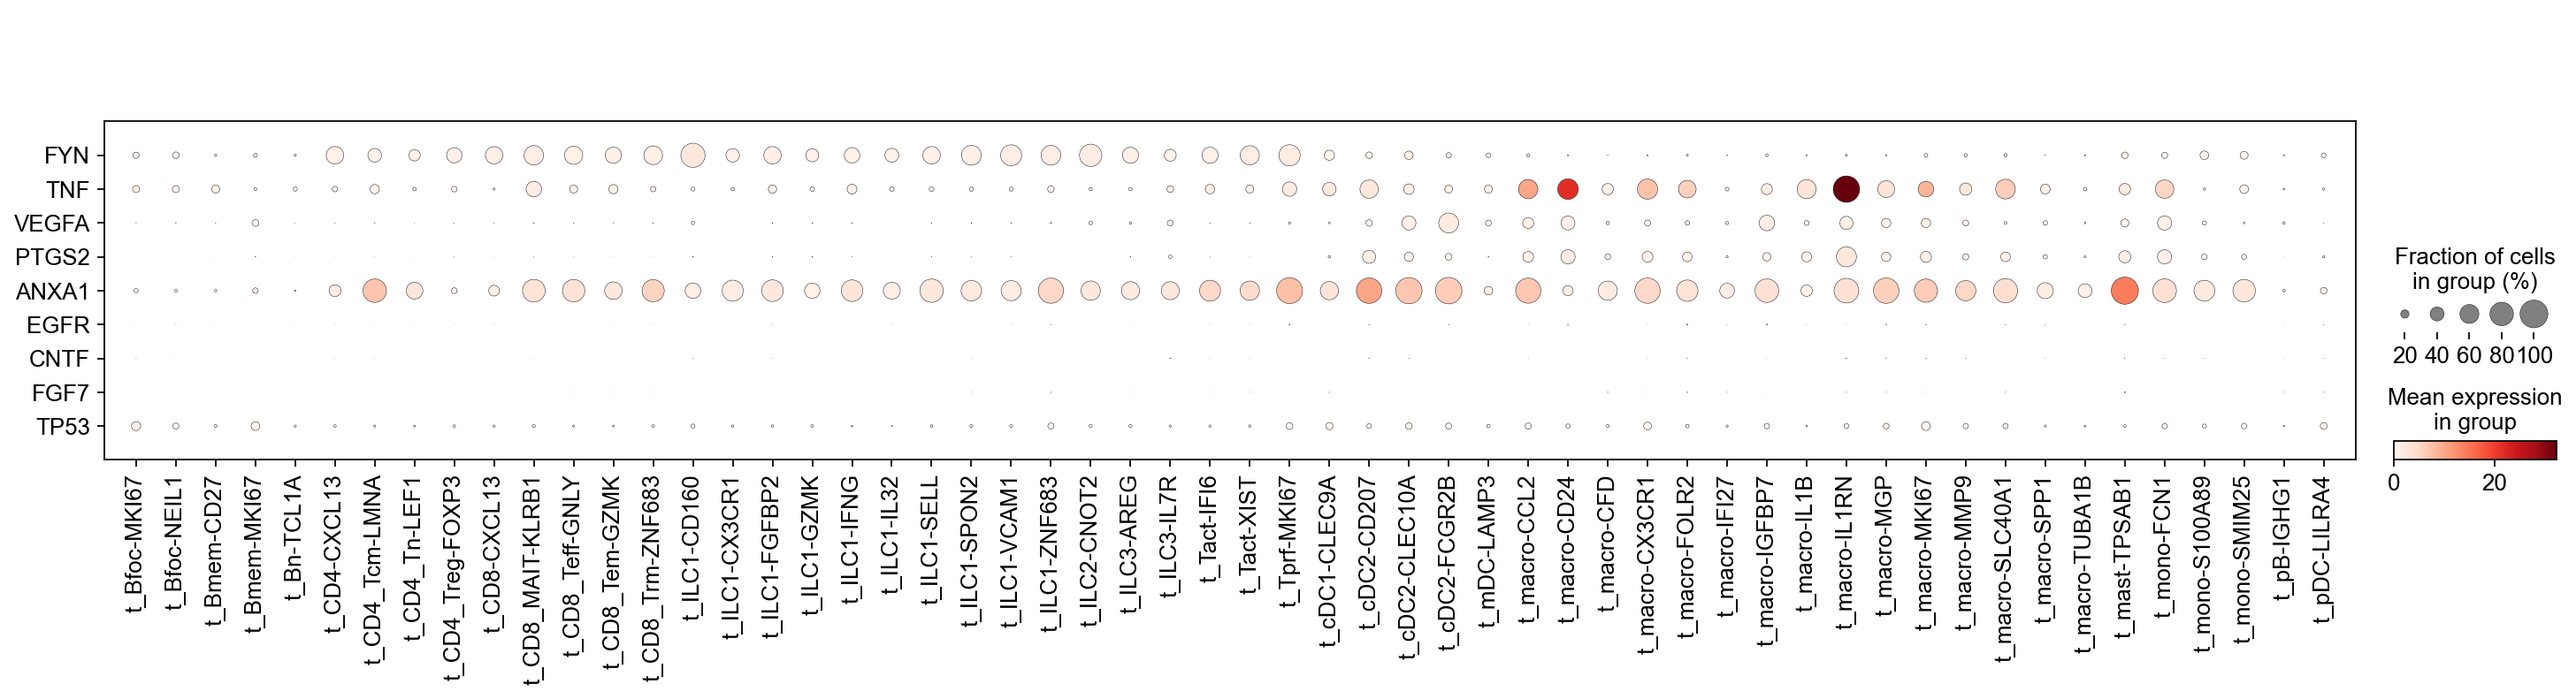

In [76]:
sc.pl.dotplot(adata, GABPA_lig['from'], 'Sub_Cluster',swap_axes=True)

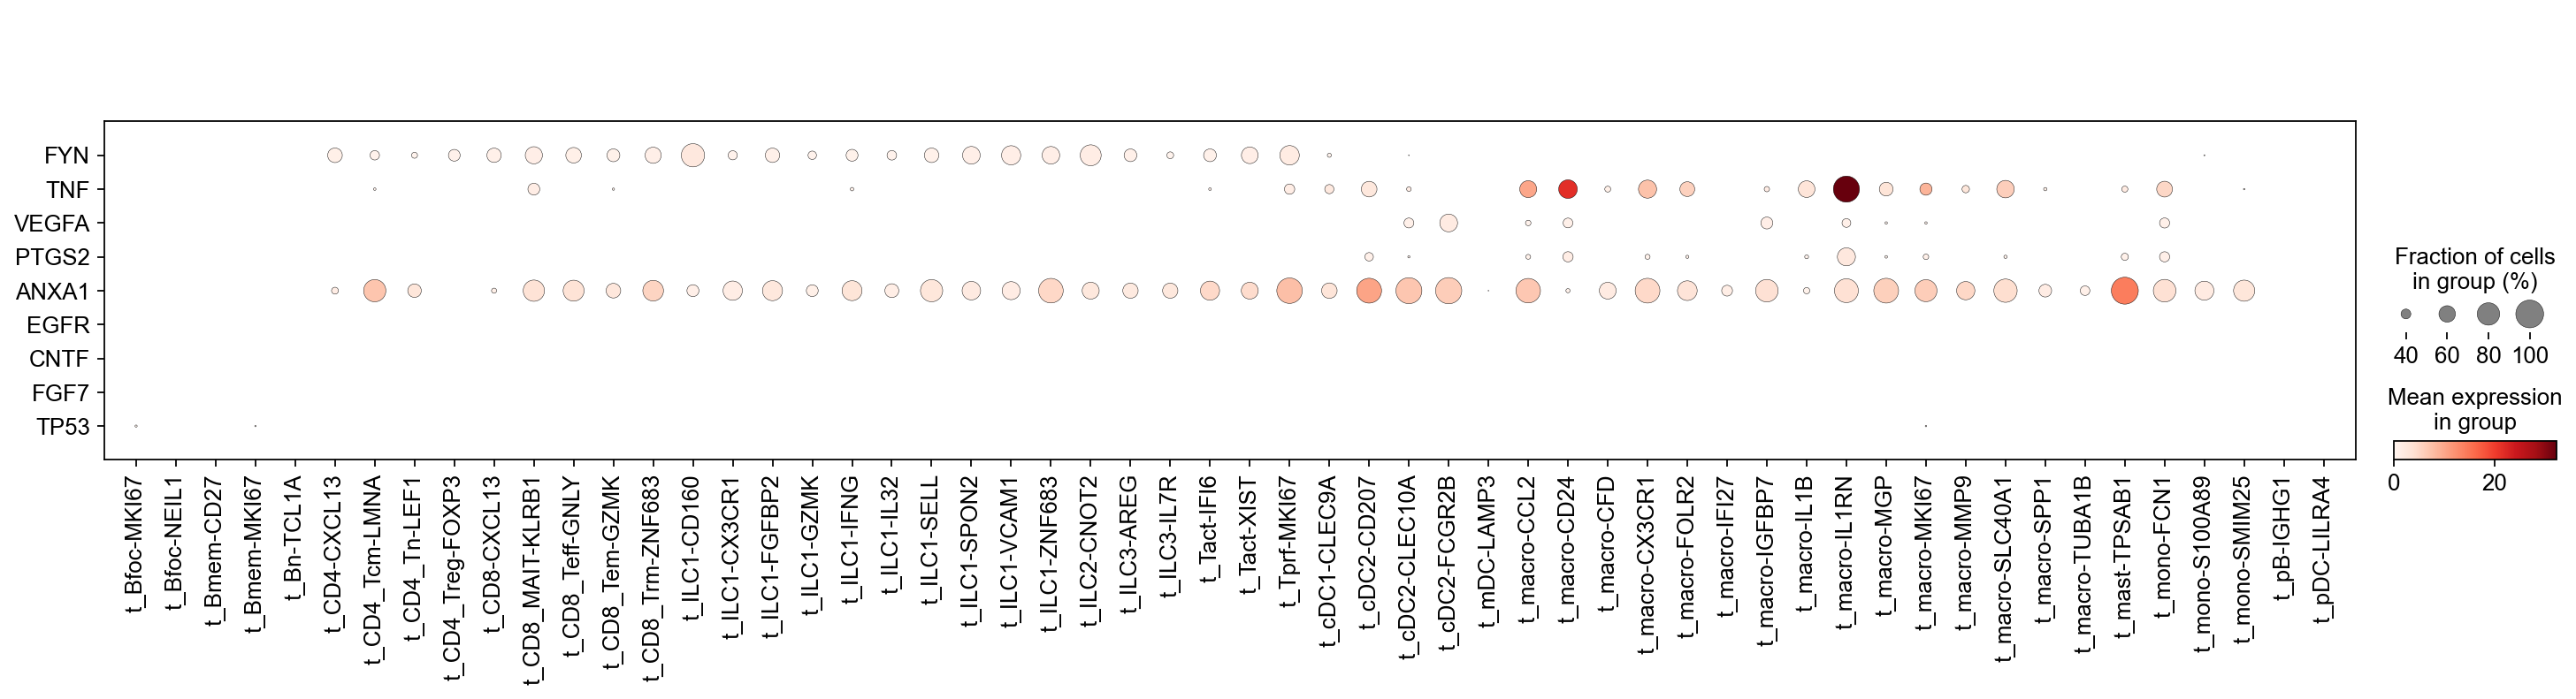

In [77]:
sc.pl.dotplot(adata, GABPA_lig['from'], 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# JUND

In [78]:
JUND_case = pd.read_csv('./result/JUND_top10_Receptor_mean_expr_regscore.csv')

In [79]:
JUND_case.index = JUND_case['receptor']

In [80]:
JUND_con = pd.read_csv('./result/JUND_top10_Receptor_mean_expr_regscore.csv')

In [81]:
JUND_con.index = JUND_con['receptor']

In [82]:
for i in JUND_case['receptor'] :
    JUND_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    JUND_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [83]:
for i in JUND_con['receptor'] :
    JUND_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    JUND_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [84]:
JUND_case['group'] = 'case'

In [85]:
JUND_con['group'] = 'control'

In [86]:
JUND_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
BCL6              0.042171     BCL6         0.352422        0.059378  case
MAPK8             0.003072    MAPK8         0.325598        0.056049  case
MAPK3             0.001060    MAPK3         0.254237        0.044395  case
MAPK9             0.001029    MAPK9         0.164940        0.028857  case
MAPK10            0.000481   MAPK10         0.000000        0.000000  case
MAGED1            0.000466   MAGED1         0.310092        0.053829  case
MAPK14            0.000428   MAPK14         0.462781        0.079911  case
MAPK11            0.000398   MAPK11         0.146132        0.026082  case
CRHR1             0.000337    CRHR1         0.000000        0.000000  case
MAP2K7            0.000308   MAP2K7         0.581240        0.100444  case

In [87]:
JUND_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
BCL6              0.042171     BCL6         0.182092        0.029983  control
MAPK8             0.003072    MAPK8         0.176814        0.028873  control
MAPK3             0.001060    MAPK3         0.204268        0.033592  control
MAPK9             0.001029    MAPK9         0.073872        0.011938  control
MAPK10            0.000481   MAPK10         0.000000        0.000000  control
MAGED1            0.000466   MAGED1         0.153238        0.024986  control
MAPK14            0.000428   MAPK14         0.210260        0.034425  control
MAPK11            0.000398   MAPK11         0.089434        0.014714  control
CRHR1             0.000337    CRHR1         0.000000        0.000000  control
MAP2K7            0.000308   MAP2K7         0.337143        0.054969  control

In [88]:
JUND = JUND_case.append(JUND_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/3130658584.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  JUND = JUND_case.append(JUND_con,ignore_index=True)


In [89]:
JUND

regulatory_score receptor  mean_expression  detection_rate    group
0           0.042171     BCL6         0.352422        0.059378     case
1           0.003072    MAPK8         0.325598        0.056049     case
2           0.001060    MAPK3         0.254237        0.044395     case
3           0.001029    MAPK9         0.164940        0.028857     case
4           0.000481   MAPK10         0.000000        0.000000     case
5           0.000466   MAGED1         0.310092        0.053829     case
6           0.000428   MAPK14         0.462781        0.079911     case
7           0.000398   MAPK11         0.146132        0.026082     case
8           0.000337    CRHR1         0.000000        0.000000     case
9           0.000308   MAP2K7         0.581240        0.100444     case
10          0.042171     BCL6         0.182092        0.029983  control
11          0.003072    MAPK8         0.176814        0.028873  control
12          0.001060    MAPK3         0.204268        0.033592  control
13          0.001029    MAPK9         0.073872        0.011938  control
14          0.000481   MAPK10         0.000000        0.000000  control
15          0.000466   MAGED1         0.153238        0.024986  control
16          0.000428   MAPK14         0.210260        0.034425  control
17          0.000398   MAPK11         0.089434        0.014714  control
18          0.000337    CRHR1         0.000000        0.000000  control
19          0.000308   MAP2K7         0.337143        0.054969  control

# MAFF

In [91]:
MAFF_case = pd.read_csv('./result/MAFF_top10_Receptor_mean_expr_regscore.csv')

In [92]:
MAFF_case.index = MAFF_case['receptor']

In [93]:
MAFF_con = pd.read_csv('./result/MAFF_top10_Receptor_mean_expr_regscore.csv')

In [94]:
MAFF_con.index = MAFF_con['receptor']

In [95]:
for i in MAFF_case['receptor'] :
    MAFF_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    MAFF_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [96]:
for i in MAFF_con['receptor'] :
    MAFF_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    MAFF_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [97]:
MAFF_case['group'] = 'case'

In [98]:
MAFF_con['group'] = 'control'

In [99]:
MAFF_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
PRKG1             0.000170    PRKG1         0.006787        0.001110  case
MAPK3             0.000030    MAPK3         0.254237        0.044395  case
PRKACB            0.000027   PRKACB         1.210097        0.203663  case
CRHR1             0.000010    CRHR1         0.000000        0.000000  case
PLD2              0.000005     PLD2         0.080096        0.013873  case
MRGPRX3           0.000005  MRGPRX3         0.000000        0.000000  case
SDC1              0.000004     SDC1         0.013319        0.002220  case
HPSE              0.000001     HPSE         0.267054        0.044950  case
TRPC3             0.000000    TRPC3         0.013358        0.002220  case
TRPV6             0.000000    TRPV6         0.000000        0.000000  case

In [100]:
MAFF_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
PRKG1             0.000170    PRKG1         0.001804        0.000278  control
MAPK3             0.000030    MAPK3         0.204268        0.033592  control
PRKACB            0.000027   PRKACB         0.850294        0.136313  control
CRHR1             0.000010    CRHR1         0.000000        0.000000  control
PLD2              0.000005     PLD2         0.022673        0.003609  control
MRGPRX3           0.000005  MRGPRX3         0.000000        0.000000  control
SDC1              0.000004     SDC1         0.007132        0.001110  control
HPSE              0.000001     HPSE         0.140151        0.022488  control
TRPC3             0.000000    TRPC3         0.004817        0.000833  control
TRPV6             0.000000    TRPV6         0.000000        0.000000  control

In [101]:
MAFF = MAFF_case.append(MAFF_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/814897545.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MAFF = MAFF_case.append(MAFF_con,ignore_index=True)


In [102]:
MAFF

regulatory_score receptor  mean_expression  detection_rate    group
0           0.000170    PRKG1         0.006787        0.001110     case
1           0.000030    MAPK3         0.254237        0.044395     case
2           0.000027   PRKACB         1.210097        0.203663     case
3           0.000010    CRHR1         0.000000        0.000000     case
4           0.000005     PLD2         0.080096        0.013873     case
5           0.000005  MRGPRX3         0.000000        0.000000     case
6           0.000004     SDC1         0.013319        0.002220     case
7           0.000001     HPSE         0.267054        0.044950     case
8           0.000000    TRPC3         0.013358        0.002220     case
9           0.000000    TRPV6         0.000000        0.000000     case
10          0.000170    PRKG1         0.001804        0.000278  control
11          0.000030    MAPK3         0.204268        0.033592  control
12          0.000027   PRKACB         0.850294        0.136313  control
13          0.000010    CRHR1         0.000000        0.000000  control
14          0.000005     PLD2         0.022673        0.003609  control
15          0.000005  MRGPRX3         0.000000        0.000000  control
16          0.000004     SDC1         0.007132        0.001110  control
17          0.000001     HPSE         0.140151        0.022488  control
18          0.000000    TRPC3         0.004817        0.000833  control
19          0.000000    TRPV6         0.000000        0.000000  control

In [103]:
for i in MAFF.index:
    rec = MAFF.loc[i,'receptor']
    MAFF.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [104]:
MAFF

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.000170    PRKG1         0.006787        0.001110     case   
1           0.000030    MAPK3         0.254237        0.044395     case   
2           0.000027   PRKACB         1.210097        0.203663     case   
3           0.000010    CRHR1         0.000000        0.000000     case   
4           0.000005     PLD2         0.080096        0.013873     case   
5           0.000005  MRGPRX3         0.000000        0.000000     case   
6           0.000004     SDC1         0.013319        0.002220     case   
7           0.000001     HPSE         0.267054        0.044950     case   
8           0.000000    TRPC3         0.013358        0.002220     case   
9           0.000000    TRPV6         0.000000        0.000000     case   
10          0.000170    PRKG1         0.001804        0.000278  control   
11          0.000030    MAPK3         0.204268        0.033592  control   
12          0.000027   PRKACB         0.850294        0.136313  control   
13          0.000010    CRHR1         0.000000        0.000000  control   
14          0.000005     PLD2         0.022673        0.003609  control   
15          0.000005  MRGPRX3         0.000000        0.000000  control   
16          0.000004     SDC1         0.007132        0.001110  control   
17          0.000001     HPSE         0.140151        0.022488  control   
18          0.000000    TRPC3         0.004817        0.000833  control   
19          0.000000    TRPV6         0.000000        0.000000  control   

    mann_whitney_u-pval  
0          1.104425e-01  
1          2.958395e-02  
2          1.608721e-08  
3          1.000000e+00  
4          1.089884e-05  
5          1.000000e+00  
6          1.590027e-01  
7          3.471552e-06  
8          9.061552e-02  
9          1.000000e+00  
10         1.104425e-01  
11         2.958395e-02  
12         1.608721e-08  
13         1.000000e+00  
14         1.089884e-05  
15         1.000000e+00  
16         1.590027e-01  
17         3.471552e-06  
18         9.061552e-02  
19         1.000000e+00

In [105]:
MAFF.to_csv('./result/MAFF_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [106]:
MAFF_lig = ligand_receptor[ligand_receptor['to'].isin(['PRKACB'])]

In [107]:
MAFF_lig

from      to
3674  CAMP  PRKACB
4939   FN1  PRKACB
5354  CSF2  PRKACB
5815   IL3  PRKACB

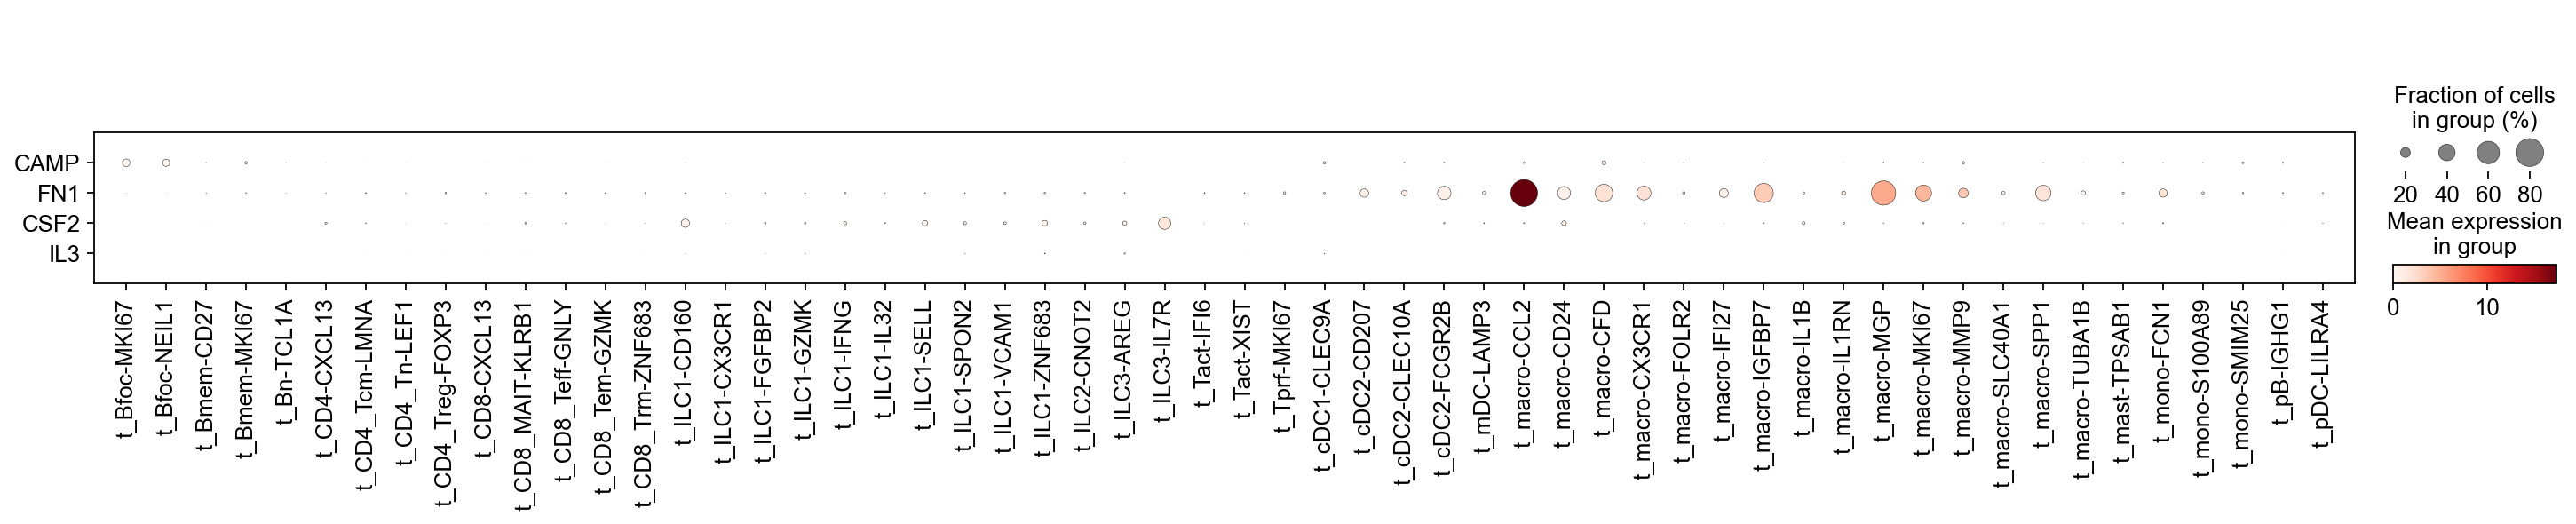

In [108]:
sc.pl.dotplot(adata, MAFF_lig['from'], 'Sub_Cluster',swap_axes=True)

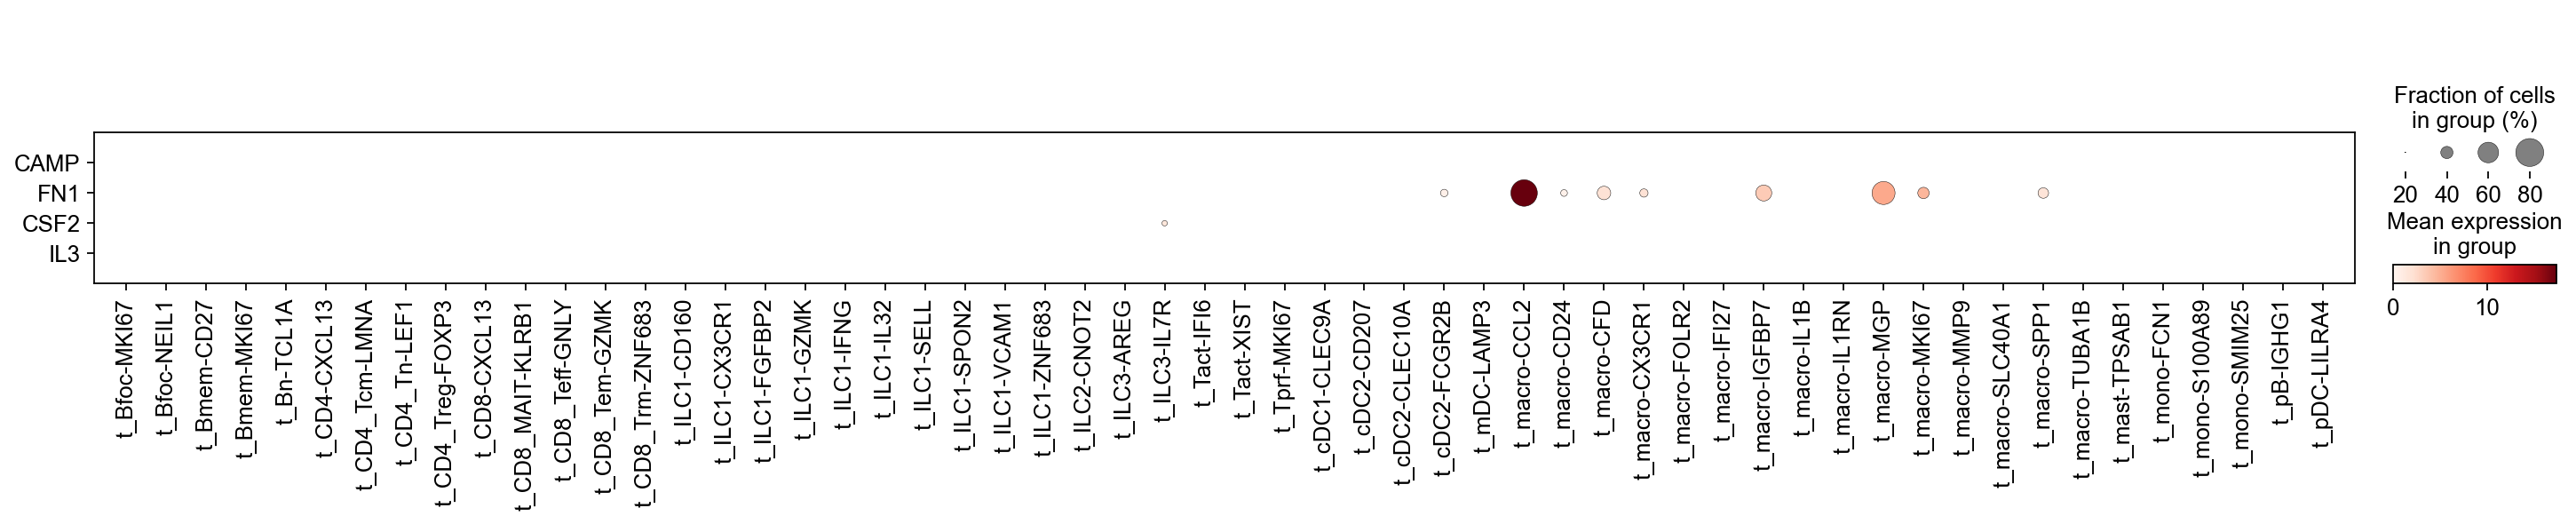

In [109]:
sc.pl.dotplot(adata, MAFF_lig['from'], 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# MTF2

In [110]:
MTF2_case = pd.read_csv('./result/MTF2_top10_Receptor_mean_expr_regscore.csv')

In [111]:
MTF2_case.index = MTF2_case['receptor']

In [112]:
MTF2_con = pd.read_csv('./result/MTF2_top10_Receptor_mean_expr_regscore.csv')

In [113]:
MTF2_con.index = MTF2_con['receptor']

In [114]:
for i in MTF2_case['receptor'] :
    MTF2_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    MTF2_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [115]:
for i in MTF2_con['receptor'] :
    MTF2_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    MTF2_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [116]:
MTF2_case['group'] = 'case'

In [117]:
MTF2_con['group'] = 'control'

In [118]:
MTF2_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
PRKD2             0.005438    PRKD2         1.026709        0.175916  case
CCKBR             0.000752    CCKBR         0.000000        0.000000  case
MAPK8             0.000157    MAPK8         0.325598        0.056049  case
ROS1              0.000128     ROS1         0.000000        0.000000  case
TRPV4             0.000109    TRPV4         0.003340        0.000555  case
MYLK              0.000080     MYLK         0.015785        0.002775  case
TRPC1             0.000050    TRPC1         0.005482        0.001110  case
PRKCE             0.000033    PRKCE         0.124986        0.022198  case
TRPC3             0.000016    TRPC3         0.013358        0.002220  case
TRPC4             0.000016    TRPC4         0.000000        0.000000  case

In [119]:
MTF2_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
PRKD2             0.005438    PRKD2         0.588371        0.095225  control
CCKBR             0.000752    CCKBR         0.000000        0.000000  control
MAPK8             0.000157    MAPK8         0.176814        0.028873  control
ROS1              0.000128     ROS1         0.000000        0.000000  control
TRPV4             0.000109    TRPV4         0.000000        0.000000  control
MYLK              0.000080     MYLK         0.021340        0.003609  control
TRPC1             0.000050    TRPC1         0.001444        0.000278  control
PRKCE             0.000033    PRKCE         0.065018        0.010550  control
TRPC3             0.000016    TRPC3         0.004817        0.000833  control
TRPC4             0.000016    TRPC4         0.000000        0.000000  control

In [120]:
MTF2 = MTF2_case.append(MTF2_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/1740751573.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MTF2 = MTF2_case.append(MTF2_con,ignore_index=True)


In [121]:
MTF2

regulatory_score receptor  mean_expression  detection_rate    group
0           0.005438    PRKD2         1.026709        0.175916     case
1           0.000752    CCKBR         0.000000        0.000000     case
2           0.000157    MAPK8         0.325598        0.056049     case
3           0.000128     ROS1         0.000000        0.000000     case
4           0.000109    TRPV4         0.003340        0.000555     case
5           0.000080     MYLK         0.015785        0.002775     case
6           0.000050    TRPC1         0.005482        0.001110     case
7           0.000033    PRKCE         0.124986        0.022198     case
8           0.000016    TRPC3         0.013358        0.002220     case
9           0.000016    TRPC4         0.000000        0.000000     case
10          0.005438    PRKD2         0.588371        0.095225  control
11          0.000752    CCKBR         0.000000        0.000000  control
12          0.000157    MAPK8         0.176814        0.028873  control
13          0.000128     ROS1         0.000000        0.000000  control
14          0.000109    TRPV4         0.000000        0.000000  control
15          0.000080     MYLK         0.021340        0.003609  control
16          0.000050    TRPC1         0.001444        0.000278  control
17          0.000033    PRKCE         0.065018        0.010550  control
18          0.000016    TRPC3         0.004817        0.000833  control
19          0.000016    TRPC4         0.000000        0.000000  control

In [122]:
for i in MTF2.index:
    rec = MTF2.loc[i,'receptor']
    MTF2.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [123]:
MTF2

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.005438    PRKD2         1.026709        0.175916     case   
1           0.000752    CCKBR         0.000000        0.000000     case   
2           0.000157    MAPK8         0.325598        0.056049     case   
3           0.000128     ROS1         0.000000        0.000000     case   
4           0.000109    TRPV4         0.003340        0.000555     case   
5           0.000080     MYLK         0.015785        0.002775     case   
6           0.000050    TRPC1         0.005482        0.001110     case   
7           0.000033    PRKCE         0.124986        0.022198     case   
8           0.000016    TRPC3         0.013358        0.002220     case   
9           0.000016    TRPC4         0.000000        0.000000     case   
10          0.005438    PRKD2         0.588371        0.095225  control   
11          0.000752    CCKBR         0.000000        0.000000  control   
12          0.000157    MAPK8         0.176814        0.028873  control   
13          0.000128     ROS1         0.000000        0.000000  control   
14          0.000109    TRPV4         0.000000        0.000000  control   
15          0.000080     MYLK         0.021340        0.003609  control   
16          0.000050    TRPC1         0.001444        0.000278  control   
17          0.000033    PRKCE         0.065018        0.010550  control   
18          0.000016    TRPC3         0.004817        0.000833  control   
19          0.000016    TRPC4         0.000000        0.000000  control   

    mann_whitney_u-pval  
0          2.027041e-15  
1          1.000000e+00  
2          6.589992e-07  
3          1.000000e+00  
4          7.876487e-02  
5          6.923101e-01  
6          1.104425e-01  
7          4.039291e-04  
8          9.061552e-02  
9          1.000000e+00  
10         2.027041e-15  
11         1.000000e+00  
12         6.589992e-07  
13         1.000000e+00  
14         7.876487e-02  
15         6.923101e-01  
16         1.104425e-01  
17         4.039291e-04  
18         9.061552e-02  
19         1.000000e+00

In [124]:
MTF2.to_csv('./result/MTF2_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [125]:
MTF2_lig = ligand_receptor[ligand_receptor['to'].isin(['PRKD2'])]

In [126]:
MTF2_lig

from     to
4092  TYK2  PRKD2

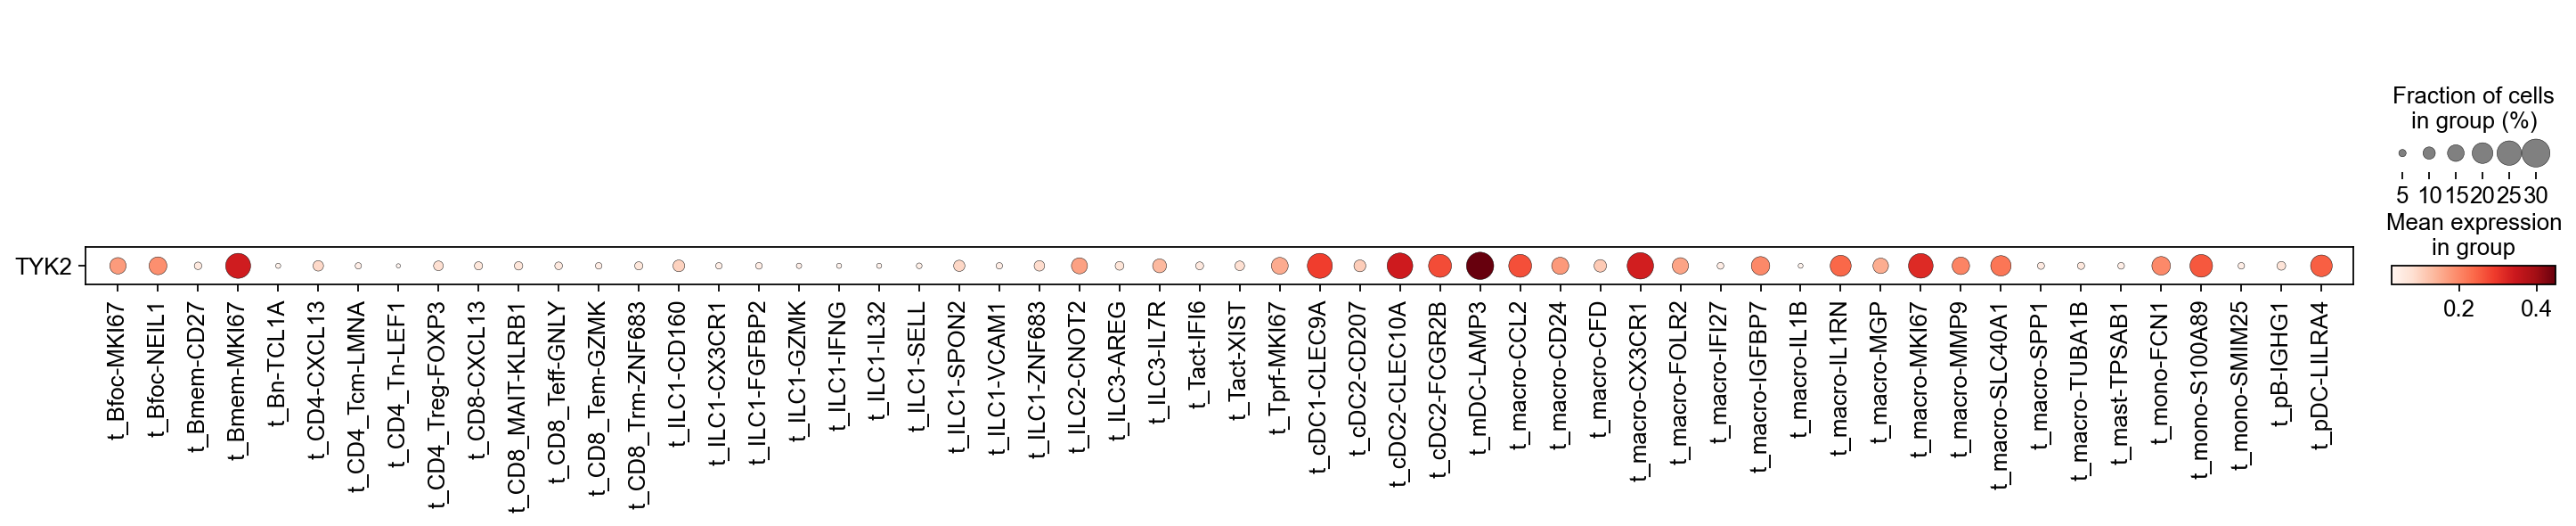

In [127]:
sc.pl.dotplot(adata, MTF2_lig['from'], 'Sub_Cluster',swap_axes=True)

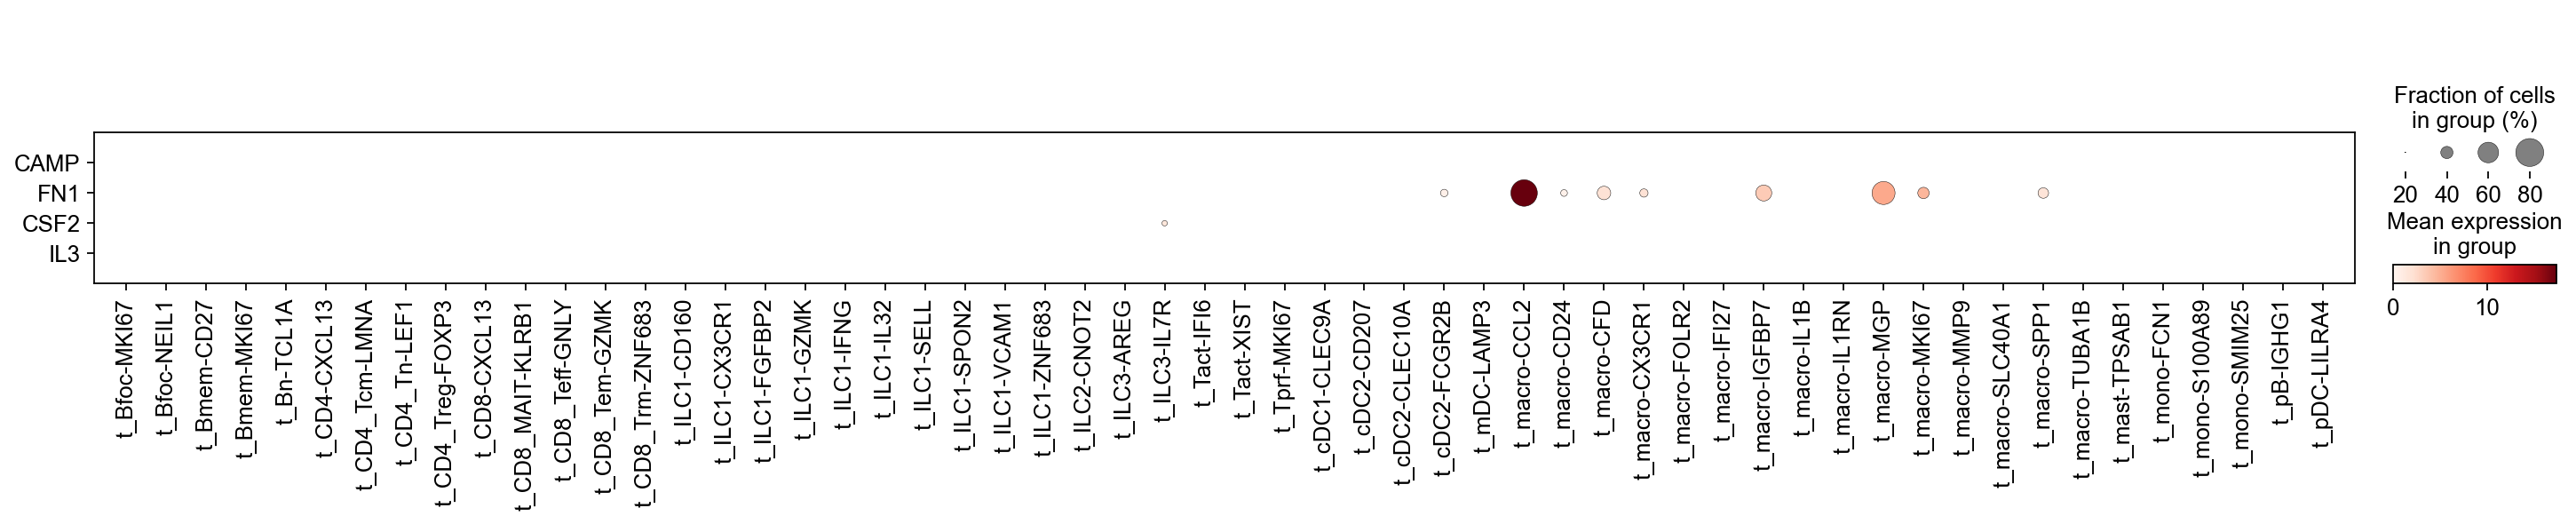

In [109]:
sc.pl.dotplot(adata, MAFF_lig['from'], 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# RARA

In [138]:
RARA_case = pd.read_csv('./result/RARA_top10_Receptor_mean_expr_regscore.csv')

In [139]:
RARA_case.index = RARA_case['receptor']

In [140]:
RARA_con = pd.read_csv('./result/RARA_top10_Receptor_mean_expr_regscore.csv')

In [141]:
RARA_con.index = RARA_con['receptor']

In [142]:
for i in RARA_case['receptor'] :
    RARA_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    RARA_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [143]:
for i in RARA_con['receptor'] :
    RARA_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    RARA_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [144]:
RARA_case['group'] = 'case'

In [145]:
RARA_con['group'] = 'control'

In [146]:
RARA_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
RARA              0.688772     RARA         0.907279        0.153718  case
THRA              0.031144     THRA         0.151781        0.026082  case
ESR2              0.022724     ESR2         0.006213        0.001110  case
RXRB              0.021224     RXRB         0.477909        0.082131  case
RXRA              0.019997     RXRA         0.108099        0.019423  case
VDR               0.006063      VDR         0.148175        0.026637  case
THRB              0.006053     THRB         0.000000        0.000000  case
RARB              0.005587     RARB         0.000000        0.000000  case
RPS6KA5           0.004852  RPS6KA5         0.465312        0.079356  case
PPARD             0.004624    PPARD         0.127049        0.022198  case

In [147]:
RARA_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
RARA              0.688772     RARA         0.391967        0.064409  control
THRA              0.031144     THRA         0.069656        0.011383  control
ESR2              0.022724     ESR2         0.004910        0.000833  control
RXRB              0.021224     RXRB         0.230499        0.037479  control
RXRA              0.019997     RXRA         0.053151        0.008884  control
VDR               0.006063      VDR         0.089882        0.014992  control
THRB              0.006053     THRB         0.000000        0.000000  control
RARB              0.005587     RARB         0.001567        0.000278  control
RPS6KA5           0.004852  RPS6KA5         0.317599        0.050805  control
PPARD             0.004624    PPARD         0.069771        0.011383  control

# SMAD3

In [149]:
SMAD3_case = pd.read_csv('./result/SMAD3_top10_Receptor_mean_expr_regscore.csv')

In [150]:
SMAD3_case.index = SMAD3_case['receptor']

In [151]:
SMAD3_con = pd.read_csv('./result/SMAD3_top10_Receptor_mean_expr_regscore.csv')

In [152]:
SMAD3_con.index = SMAD3_con['receptor']

In [153]:
for i in SMAD3_case['receptor'] :
    SMAD3_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    SMAD3_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

/Users/liupeiwen/python/anaconda3/lib/python3.8/site-packages/scipy/sparse/base.py:581: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


In [154]:
for i in SMAD3_con['receptor'] :
    SMAD3_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    SMAD3_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

/Users/liupeiwen/python/anaconda3/lib/python3.8/site-packages/scipy/sparse/base.py:581: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


In [155]:
SMAD3_case['group'] = 'case'

In [156]:
SMAD3_con['group'] = 'control'

In [157]:
SMAD3_case

regulatory_score       receptor  mean_expression  \
receptor                                                          
SMAD3                  0.688672          SMAD3         0.365614   
TGFBR1_TGFBR2          0.112727  TGFBR1_TGFBR2         0.000000   
TUBB                   0.107180           TUBB         2.153283   
NOX1                   0.070892           NOX1         0.000000   
ACVR1C                 0.064753         ACVR1C         0.003068   
PIK3C2A                0.022131        PIK3C2A         0.390665   
HDAC1                  0.012724          HDAC1         1.153253   
NR3C1                  0.012284          NR3C1         4.381542   
CSNK1G2                0.012087        CSNK1G2         0.506875   
KAT2B                  0.010179          KAT2B         0.280317   

               detection_rate group  
receptor                             
SMAD3                0.062708  case  
TGFBR1_TGFBR2        0.000000  case  
TUBB                 0.349612  case  
NOX1                 0.000000  case  
ACVR1C               0.000555  case  
PIK3C2A              0.066593  case  
HDAC1                0.197558  case  
NR3C1                0.667037  case  
CSNK1G2              0.088235  case  
KAT2B                0.048835  case

In [158]:
SMAD3_con

regulatory_score       receptor  mean_expression  \
receptor                                                          
SMAD3                  0.688672          SMAD3         0.170868   
TGFBR1_TGFBR2          0.112727  TGFBR1_TGFBR2         0.000000   
TUBB                   0.107180           TUBB         1.835537   
NOX1                   0.070892           NOX1         0.000000   
ACVR1C                 0.064753         ACVR1C         0.006524   
PIK3C2A                0.022131        PIK3C2A         0.231441   
HDAC1                  0.012724          HDAC1         0.704671   
NR3C1                  0.012284          NR3C1         2.709163   
CSNK1G2                0.012087        CSNK1G2         0.322848   
KAT2B                  0.010179          KAT2B         0.183605   

               detection_rate    group  
receptor                                
SMAD3                0.027762  control  
TGFBR1_TGFBR2        0.000000  control  
TUBB                 0.286507  control  
NOX1                 0.000000  control  
ACVR1C               0.001110  control  
PIK3C2A              0.037479  control  
HDAC1                0.114381  control  
NR3C1                0.416158  control  
CSNK1G2              0.052748  control  
KAT2B                0.029983  control

In [159]:
SMAD3 = SMAD3_case.append(SMAD3_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/3052923302.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SMAD3 = SMAD3_case.append(SMAD3_con,ignore_index=True)


In [173]:
SMAD3

regulatory_score       receptor  mean_expression  detection_rate    group  \
0           0.688672          SMAD3         0.365614        0.062708     case   
1           0.112727  TGFBR1_TGFBR2         0.000000        0.000000     case   
2           0.107180           TUBB         2.153283        0.349612     case   
3           0.070892           NOX1         0.000000        0.000000     case   
4           0.064753         ACVR1C         0.003068        0.000555     case   
5           0.022131        PIK3C2A         0.390665        0.066593     case   
6           0.012724          HDAC1         1.153253        0.197558     case   
7           0.012284          NR3C1         4.381542        0.667037     case   
8           0.012087        CSNK1G2         0.506875        0.088235     case   
9           0.010179          KAT2B         0.280317        0.048835     case   
10          0.688672          SMAD3         0.170868        0.027762  control   
11          0.112727  TGFBR1_TGFBR2         0.000000        0.000000  control   
12          0.107180           TUBB         1.835537        0.286507  control   
13          0.070892           NOX1         0.000000        0.000000  control   
14          0.064753         ACVR1C         0.006524        0.001110  control   
15          0.022131        PIK3C2A         0.231441        0.037479  control   
16          0.012724          HDAC1         0.704671        0.114381  control   
17          0.012284          NR3C1         2.709163        0.416158  control   
18          0.012087        CSNK1G2         0.322848        0.052748  control   
19          0.010179          KAT2B         0.183605        0.029983  control   

    mann_whitney_u-pval  
0          4.953928e-10  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN  
5                   NaN  
6                   NaN  
7                   NaN  
8                   NaN  
9                   NaN  
10                  NaN  
11                  NaN  
12                  NaN  
13                  NaN  
14                  NaN  
15                  NaN  
16                  NaN  
17                  NaN  
18                  NaN  
19                  NaN

In [176]:
SMAD3.loc[1,'receptor']

'TGFBR1_TGFBR2'

In [178]:
for i in SMAD3.index:
    if (SMAD3.loc[i,'receptor'] != 'TGFBR1_TGFBR2') & (SMAD3.loc[i,'receptor'] != 'NOX1'):
        rec = SMAD3.loc[i,'receptor']
        SMAD3.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [179]:
SMAD3

regulatory_score       receptor  mean_expression  detection_rate    group  \
0           0.688672          SMAD3         0.365614        0.062708     case   
1           0.112727  TGFBR1_TGFBR2         0.000000        0.000000     case   
2           0.107180           TUBB         2.153283        0.349612     case   
3           0.070892           NOX1         0.000000        0.000000     case   
4           0.064753         ACVR1C         0.003068        0.000555     case   
5           0.022131        PIK3C2A         0.390665        0.066593     case   
6           0.012724          HDAC1         1.153253        0.197558     case   
7           0.012284          NR3C1         4.381542        0.667037     case   
8           0.012087        CSNK1G2         0.506875        0.088235     case   
9           0.010179          KAT2B         0.280317        0.048835     case   
10          0.688672          SMAD3         0.170868        0.027762  control   
11          0.112727  TGFBR1_TGFBR2         0.000000        0.000000  control   
12          0.107180           TUBB         1.835537        0.286507  control   
13          0.070892           NOX1         0.000000        0.000000  control   
14          0.064753         ACVR1C         0.006524        0.001110  control   
15          0.022131        PIK3C2A         0.231441        0.037479  control   
16          0.012724          HDAC1         0.704671        0.114381  control   
17          0.012284          NR3C1         2.709163        0.416158  control   
18          0.012087        CSNK1G2         0.322848        0.052748  control   
19          0.010179          KAT2B         0.183605        0.029983  control   

    mann_whitney_u-pval  
0          4.953928e-10  
1                   NaN  
2          5.171247e-03  
3                   NaN  
4          7.368758e-01  
5          2.051003e-06  
6          6.077900e-14  
7          4.036639e-65  
8          1.019838e-06  
9          3.620468e-04  
10         4.953928e-10  
11                  NaN  
12         5.171247e-03  
13                  NaN  
14         7.368758e-01  
15         2.051003e-06  
16         6.077900e-14  
17         4.036639e-65  
18         1.019838e-06  
19         3.620468e-04

In [180]:
SMAD3.to_csv('./result/SMAD3_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [181]:
SMAD3_lig = ligand_receptor[ligand_receptor['to'].isin(['TUBB','NR3C1'])]

In [182]:
SMAD3_lig

from     to
3917  HSP90AA1  NR3C1
3924    HSPA1A  NR3C1
4098      TP53  NR3C1
4509       TNF  NR3C1
4511      LCN2  NR3C1
4512        GC  NR3C1
5237       SYK   TUBB
5596       FYN   TUBB
6037     NR0B2  NR3C1
6585      RLN1  NR3C1

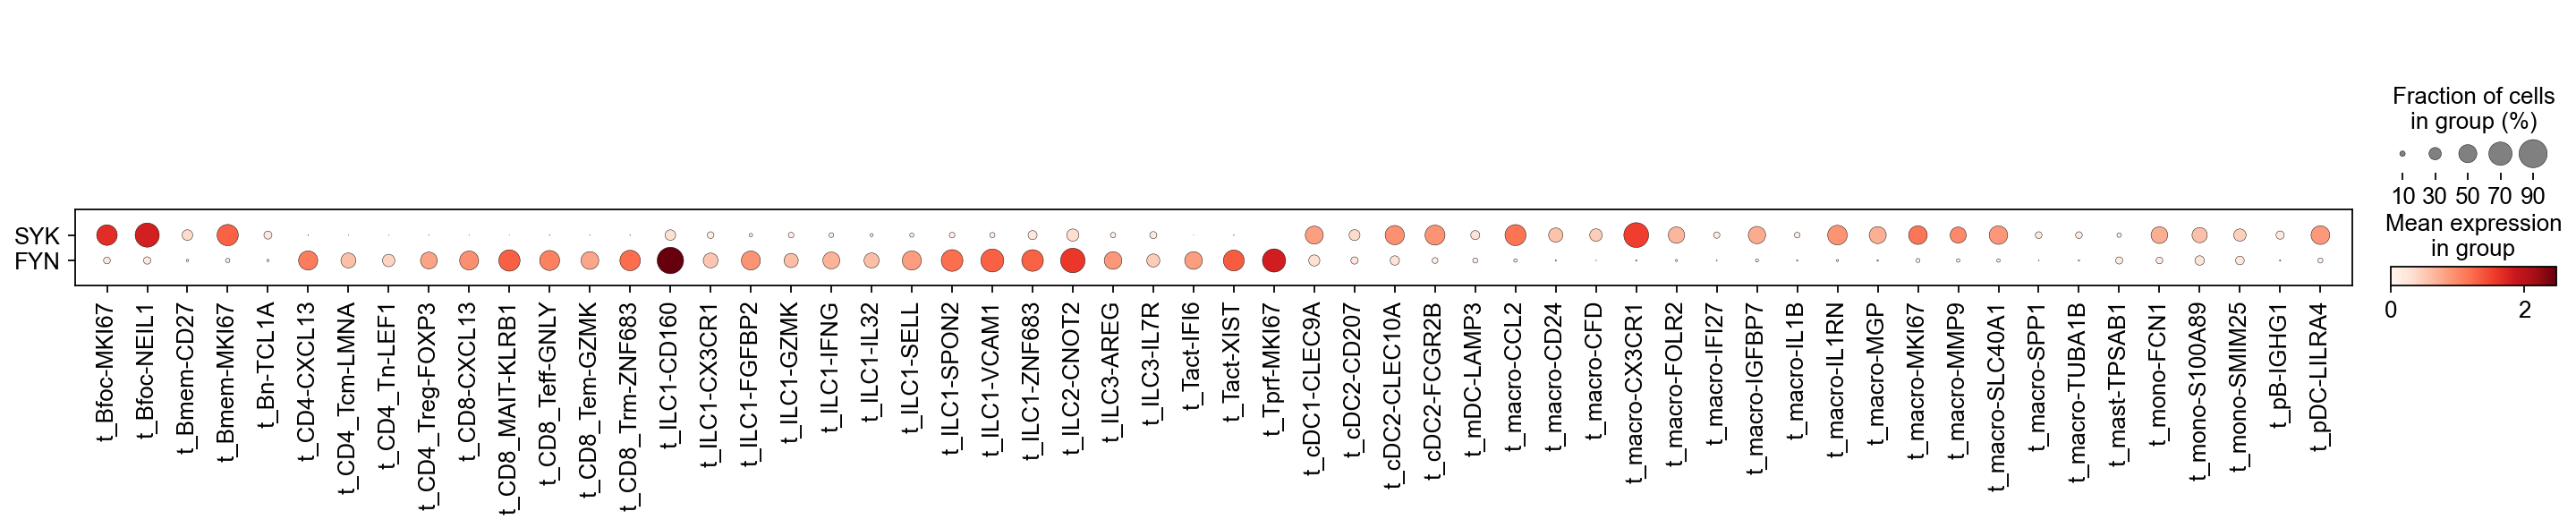

In [184]:
sc.pl.dotplot(adata, ['SYK','FYN'], 'Sub_Cluster',swap_axes=True)

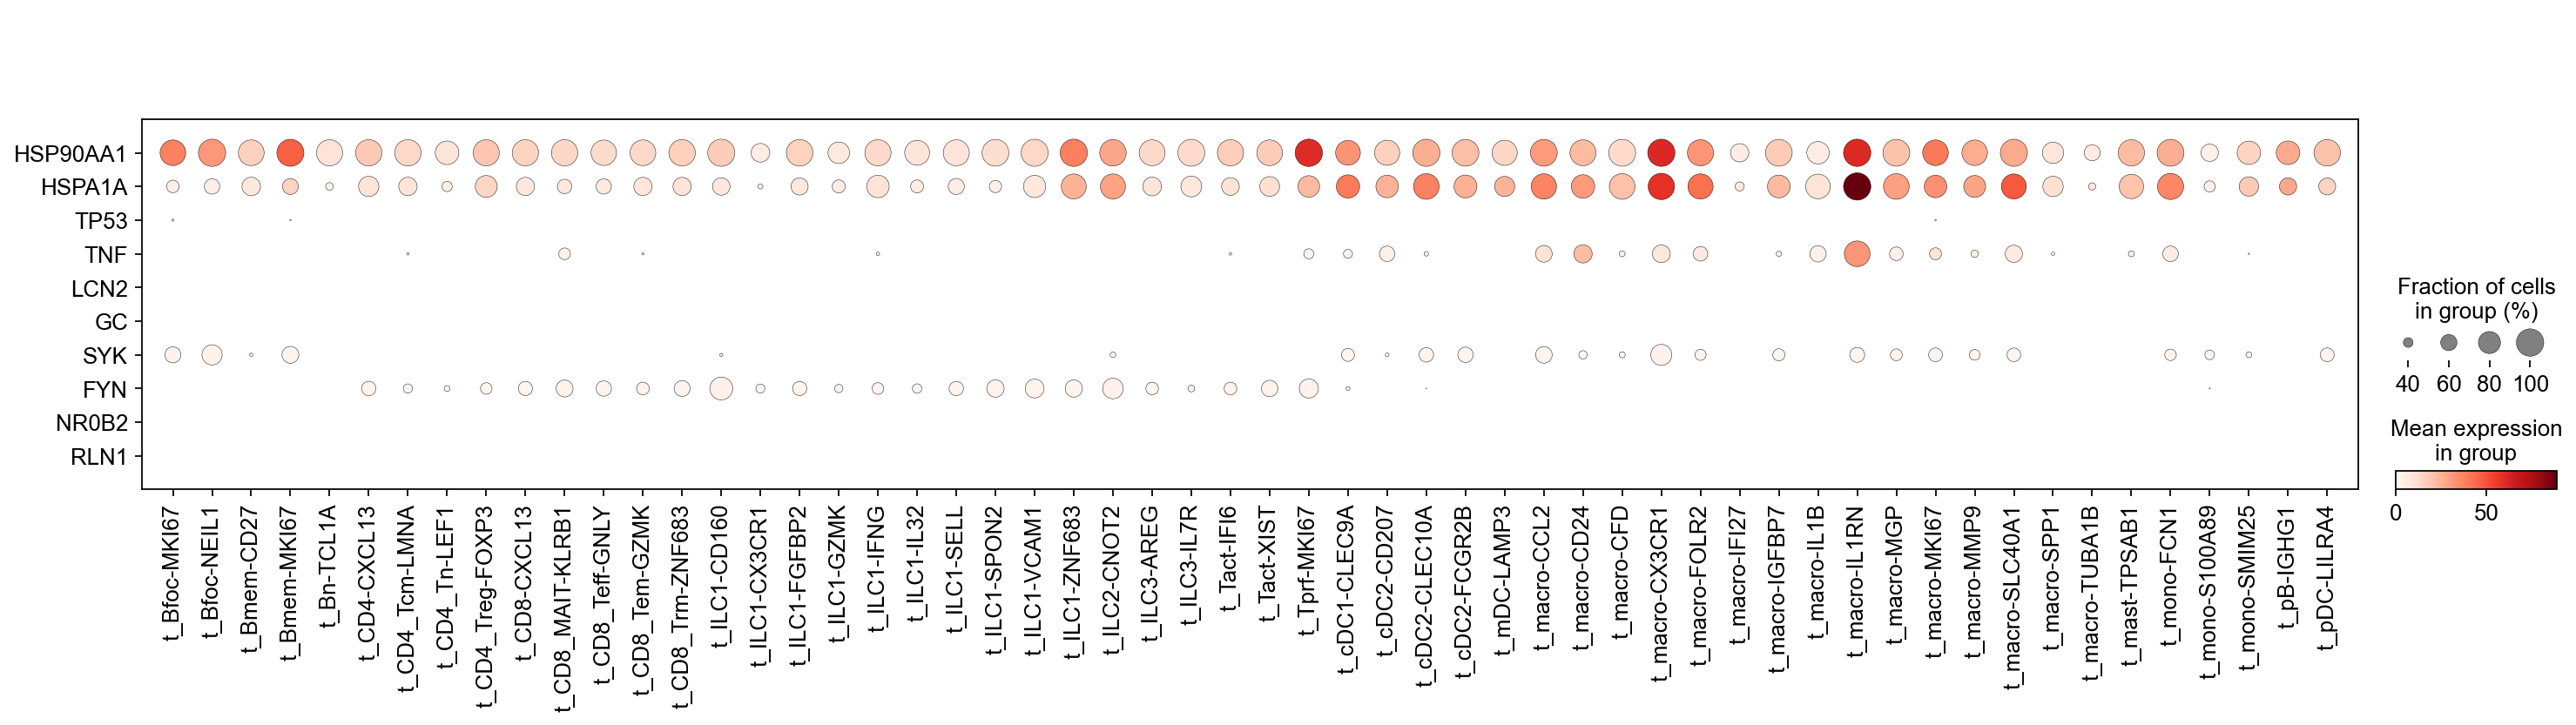

In [185]:
sc.pl.dotplot(adata, SMAD3_lig['from'], 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# TBX21

In [186]:
TBX21_case = pd.read_csv('./result/TBX21_top10_Receptor_mean_expr_regscore.csv')

In [187]:
TBX21_case.index = TBX21_case['receptor']

In [188]:
TBX21_con = pd.read_csv('./result/TBX21_top10_Receptor_mean_expr_regscore.csv')

In [189]:
TBX21_con.index = TBX21_con['receptor']

In [190]:
for i in TBX21_case['receptor'] :
    TBX21_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    TBX21_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [191]:
for i in TBX21_con['receptor'] :
    TBX21_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    TBX21_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [193]:
TBX21_case['group'] = 'case'

In [192]:
TBX21_con['group'] = 'control'

In [194]:
TBX21_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
IL12RB1           0.008120  IL12RB1         0.690200        0.118757  case
IL12RB2           0.005595  IL12RB2         0.041826        0.007769  case
NOS2              0.001727     NOS2         0.000000        0.000000  case
RPS6KA3           0.001583  RPS6KA3         0.841907        0.144284  case
ABL1              0.001015     ABL1         0.103139        0.018313  case
NR3C1             0.000850    NR3C1         4.381542        0.667037  case
CYP2E1            0.000558   CYP2E1         0.003245        0.000555  case
STAT6             0.000501    STAT6         0.705500        0.120977  case
ODC1              0.000296     ODC1         2.308690        0.378468  case
GBA               0.000274      GBA         0.352332        0.061598  case

In [158]:
TBX21_con

regulatory_score       receptor  mean_expression  \
receptor                                                          
SMAD3                  0.688672          SMAD3         0.170868   
TGFBR1_TGFBR2          0.112727  TGFBR1_TGFBR2         0.000000   
TUBB                   0.107180           TUBB         1.835537   
NOX1                   0.070892           NOX1         0.000000   
ACVR1C                 0.064753         ACVR1C         0.006524   
PIK3C2A                0.022131        PIK3C2A         0.231441   
HDAC1                  0.012724          HDAC1         0.704671   
NR3C1                  0.012284          NR3C1         2.709163   
CSNK1G2                0.012087        CSNK1G2         0.322848   
KAT2B                  0.010179          KAT2B         0.183605   

               detection_rate    group  
receptor                                
SMAD3                0.027762  control  
TGFBR1_TGFBR2        0.000000  control  
TUBB                 0.286507  control  
NOX1                 0.000000  control  
ACVR1C               0.001110  control  
PIK3C2A              0.037479  control  
HDAC1                0.114381  control  
NR3C1                0.416158  control  
CSNK1G2              0.052748  control  
KAT2B                0.029983  control

In [195]:
TBX21 = TBX21_case.append(TBX21_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/292620669.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TBX21 = TBX21_case.append(TBX21_con,ignore_index=True)


In [196]:
TBX21

regulatory_score receptor  mean_expression  detection_rate    group
0           0.008120  IL12RB1         0.690200        0.118757     case
1           0.005595  IL12RB2         0.041826        0.007769     case
2           0.001727     NOS2         0.000000        0.000000     case
3           0.001583  RPS6KA3         0.841907        0.144284     case
4           0.001015     ABL1         0.103139        0.018313     case
5           0.000850    NR3C1         4.381542        0.667037     case
6           0.000558   CYP2E1         0.003245        0.000555     case
7           0.000501    STAT6         0.705500        0.120977     case
8           0.000296     ODC1         2.308690        0.378468     case
9           0.000274      GBA         0.352332        0.061598     case
10          0.008120  IL12RB1         0.450274        0.072737  control
11          0.005595  IL12RB2         0.037055        0.006385  control
12          0.001727     NOS2         0.000000        0.000000  control
13          0.001583  RPS6KA3         0.448311        0.073015  control
14          0.001015     ABL1         0.063869        0.010550  control
15          0.000850    NR3C1         2.709163        0.416158  control
16          0.000558   CYP2E1         0.001499        0.000278  control
17          0.000501    STAT6         0.369992        0.059689  control
18          0.000296     ODC1         1.733206        0.272349  control
19          0.000274      GBA         0.183163        0.029983  control

In [197]:
for i in TBX21.index:
    rec = TBX21.loc[i,'receptor']
    TBX21.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [198]:
TBX21

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.008120  IL12RB1         0.690200        0.118757     case   
1           0.005595  IL12RB2         0.041826        0.007769     case   
2           0.001727     NOS2         0.000000        0.000000     case   
3           0.001583  RPS6KA3         0.841907        0.144284     case   
4           0.001015     ABL1         0.103139        0.018313     case   
5           0.000850    NR3C1         4.381542        0.667037     case   
6           0.000558   CYP2E1         0.003245        0.000555     case   
7           0.000501    STAT6         0.705500        0.120977     case   
8           0.000296     ODC1         2.308690        0.378468     case   
9           0.000274      GBA         0.352332        0.061598     case   
10          0.008120  IL12RB1         0.450274        0.072737  control   
11          0.005595  IL12RB2         0.037055        0.006385  control   
12          0.001727     NOS2         0.000000        0.000000  control   
13          0.001583  RPS6KA3         0.448311        0.073015  control   
14          0.001015     ABL1         0.063869        0.010550  control   
15          0.000850    NR3C1         2.709163        0.416158  control   
16          0.000558   CYP2E1         0.001499        0.000278  control   
17          0.000501    STAT6         0.369992        0.059689  control   
18          0.000296     ODC1         1.733206        0.272349  control   
19          0.000274      GBA         0.183163        0.029983  control   

    mann_whitney_u-pval  
0          9.945650e-08  
1          2.838765e-01  
2          1.000000e+00  
3          1.118321e-15  
4          9.663174e-03  
5          4.036639e-65  
6          3.086678e-01  
7          4.762250e-14  
8          2.971909e-09  
9          2.995437e-08  
10         9.945650e-08  
11         2.838765e-01  
12         1.000000e+00  
13         1.118321e-15  
14         9.663174e-03  
15         4.036639e-65  
16         3.086678e-01  
17         4.762250e-14  
18         2.971909e-09  
19         2.995437e-08

In [199]:
TBX21.to_csv('./result/TBX21_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [202]:
TBX21_lig = ligand_receptor[ligand_receptor['to'].isin(['ODC1'])]

In [203]:
TBX21_lig

from    to
3574  TP53  ODC1
4842   CCK  ODC1
5263   NPY  ODC1
5802  FGF2  ODC1
5958   PTH  ODC1
6185   HGF  ODC1
6300   PRL  ODC1
6750   IL2  ODC1

In [205]:
TBX21_lig1 = pd.unique(TBX21_lig['from'])

In [206]:
TBX21_lig1

array(['TP53', 'CCK', 'NPY', 'FGF2', 'PTH', 'HGF', 'PRL', 'IL2'],
      dtype=object)

In [207]:
TBX21_lig1 = np.delete(TBX21_lig1,4)

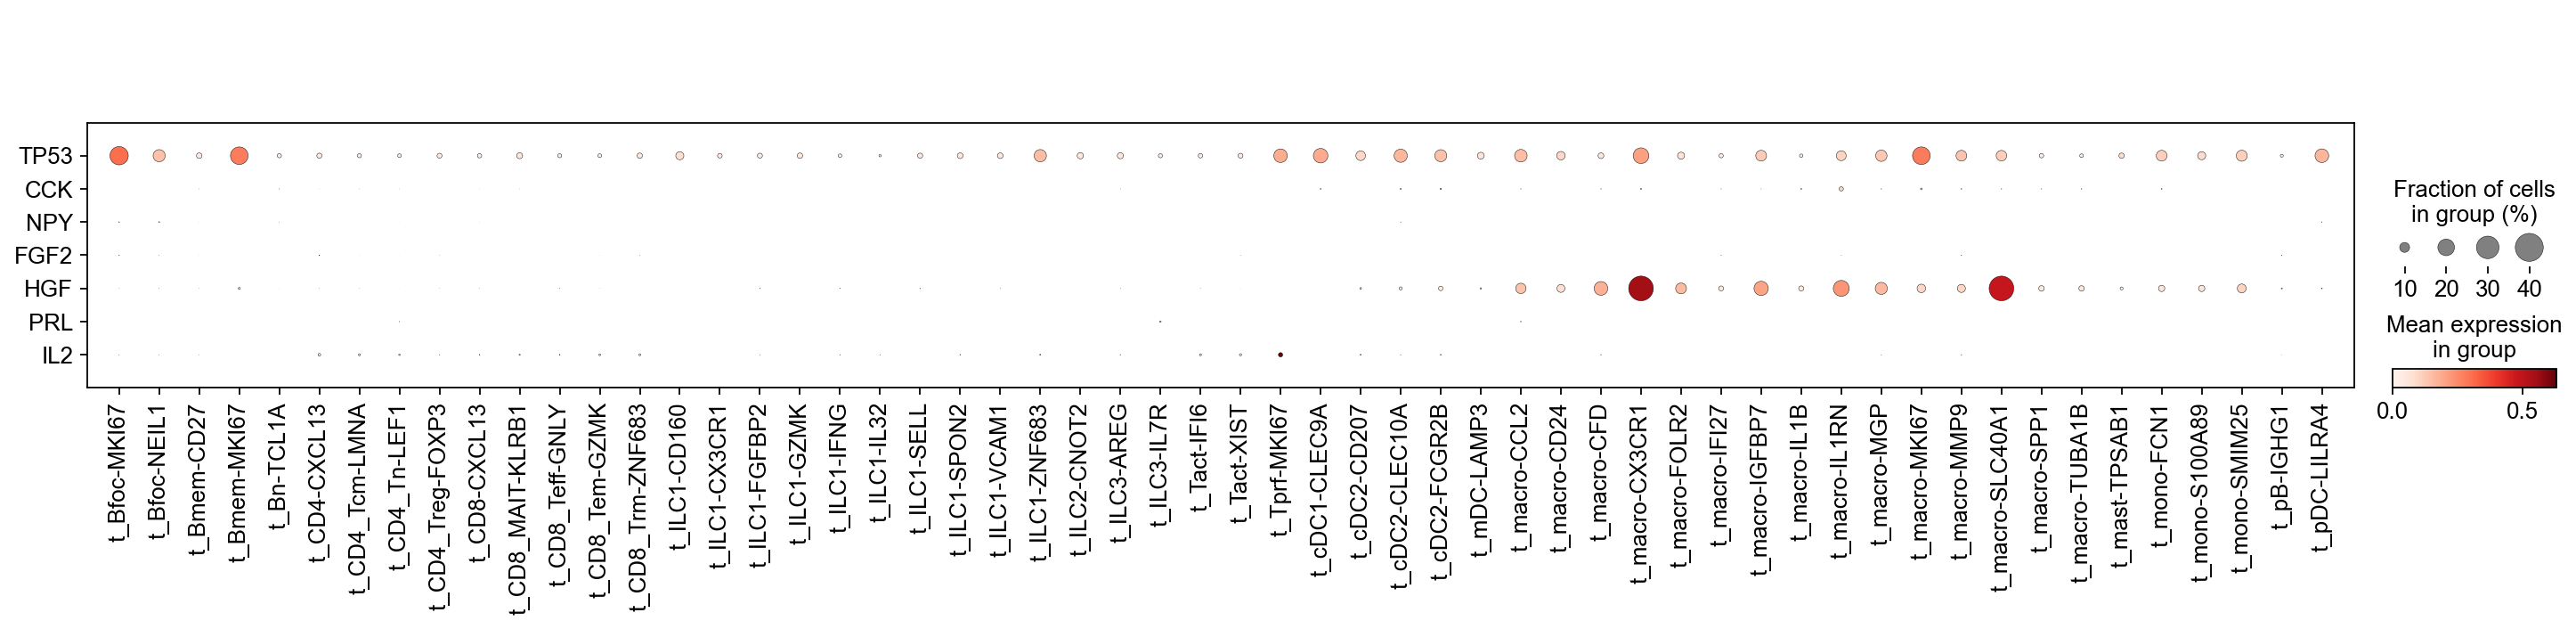

In [208]:
sc.pl.dotplot(adata, TBX21_lig1, 'Sub_Cluster',swap_axes=True)

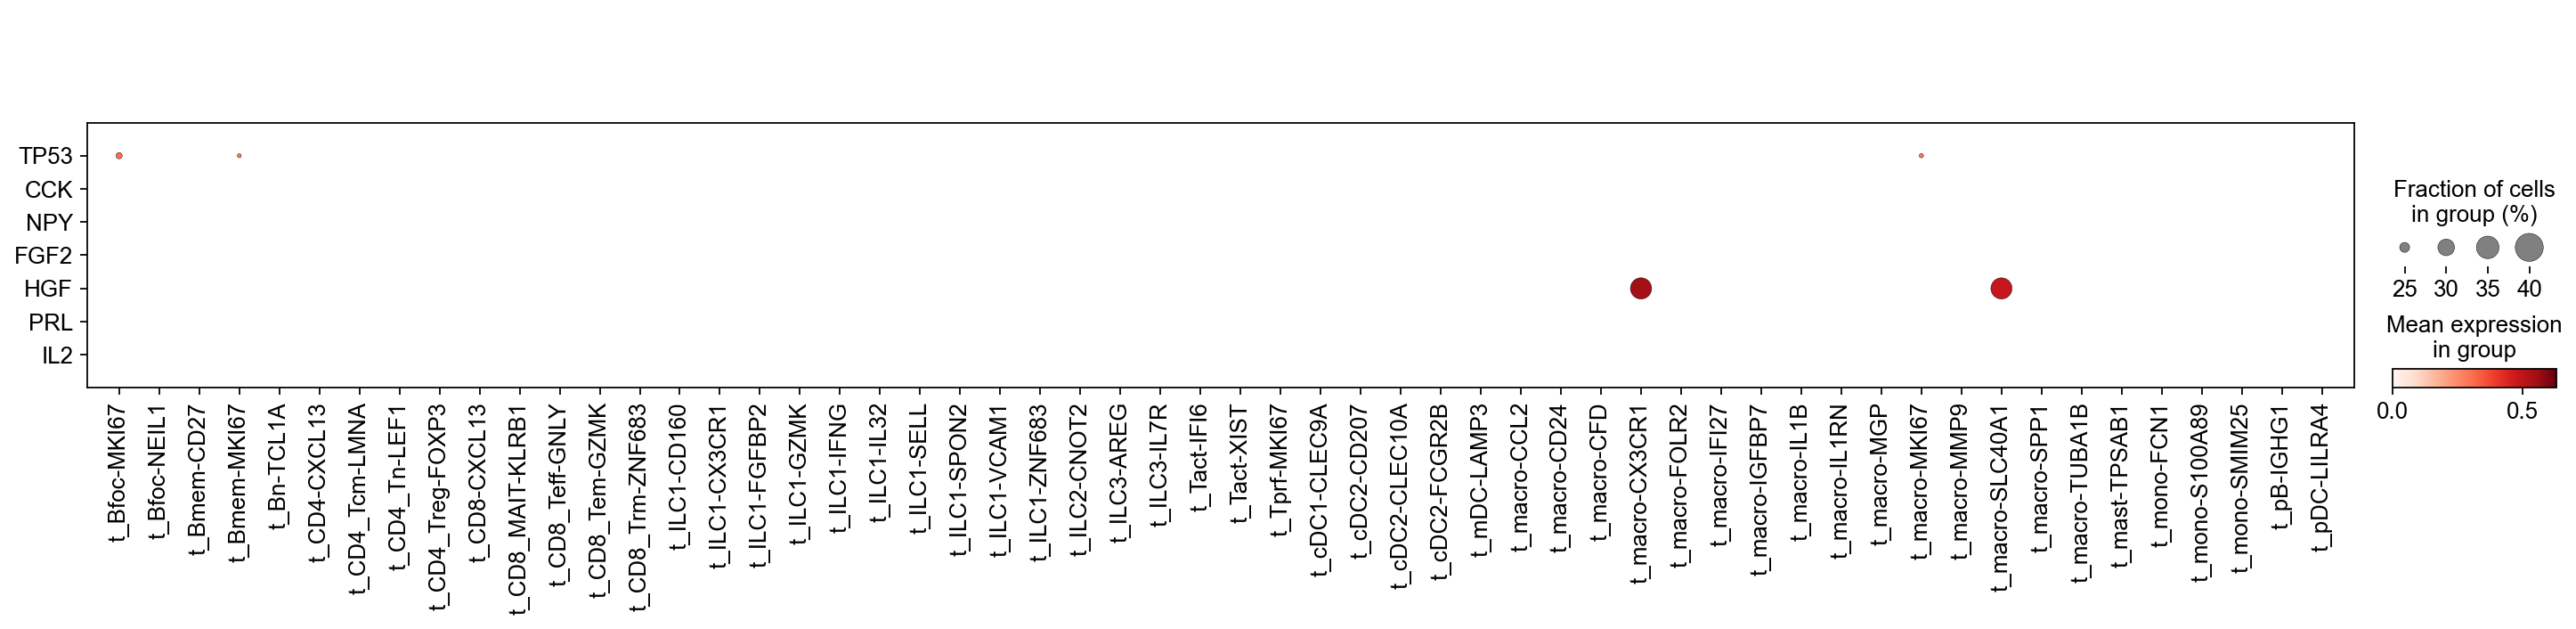

In [209]:
sc.pl.dotplot(adata, TBX21_lig1, 'Sub_Cluster',swap_axes=True,dot_min=0.2)

# ZFX

In [210]:
ZFX_case = pd.read_csv('./result/ZFX_top10_Receptor_mean_expr_regscore.csv')

In [211]:
ZFX_case.index = ZFX_case['receptor']

In [212]:
ZFX_con = pd.read_csv('./result/ZFX_top10_Receptor_mean_expr_regscore.csv')

In [213]:
ZFX_con.index = ZFX_con['receptor']

In [214]:
for i in ZFX_case['receptor'] :
    ZFX_case.loc[i, 'mean_expression'] = case[:,case.var_names == i].X.mean()
    ZFX_case.loc[i, 'detection_rate'] = np.count_nonzero(case[:,case.var_names == i].to_df()) / len(case)

In [215]:
for i in ZFX_con['receptor'] :
    ZFX_con.loc[i, 'mean_expression'] = control[:,control.var_names == i].X.mean()
    ZFX_con.loc[i, 'detection_rate'] = np.count_nonzero(control[:,control.var_names == i].to_df()) / len(control)

In [216]:
ZFX_case['group'] = 'case'

In [217]:
ZFX_con['group'] = 'control'

In [218]:
ZFX_case

regulatory_score receptor  mean_expression  detection_rate group
receptor                                                                  
CSNK2A2           0.000249  CSNK2A2         0.139255        0.024417  case
TRPC3             0.000000    TRPC3         0.013358        0.002220  case
TRPV6             0.000000    TRPV6         0.000000        0.000000  case
FZD2              0.000000     FZD2         0.000000        0.000000  case
CXCR6             0.000000    CXCR6         1.987391        0.315205  case
CCR5              0.000000     CCR5         0.780791        0.132075  case
IL10RA            0.000000   IL10RA         2.500225        0.408435  case
FLT3              0.000000     FLT3         0.000000        0.000000  case
CXCR3             0.000000    CXCR3         1.861660        0.309101  case
LRP6              0.000000     LRP6         0.015540        0.002775  case

In [219]:
ZFX_con

regulatory_score receptor  mean_expression  detection_rate    group
receptor                                                                     
CSNK2A2           0.000249  CSNK2A2         0.073995        0.012215  control
TRPC3             0.000000    TRPC3         0.004817        0.000833  control
TRPV6             0.000000    TRPV6         0.000000        0.000000  control
FZD2              0.000000     FZD2         0.000000        0.000000  control
CXCR6             0.000000    CXCR6         1.910151        0.290117  control
CCR5              0.000000     CCR5         0.542839        0.086896  control
IL10RA            0.000000   IL10RA         1.364229        0.215436  control
FLT3              0.000000     FLT3         0.000000        0.000000  control
CXCR3             0.000000    CXCR3         1.666077        0.262354  control
LRP6              0.000000     LRP6         0.008579        0.001388  control

In [220]:
ZFX = ZFX_case.append(ZFX_con,ignore_index=True)

/var/folders/3f/l01mb30n3815clzkmj3ygt7w0000gn/T/ipykernel_35919/4266273776.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ZFX = ZFX_case.append(ZFX_con,ignore_index=True)


In [221]:
ZFX

regulatory_score receptor  mean_expression  detection_rate    group
0           0.000249  CSNK2A2         0.139255        0.024417     case
1           0.000000    TRPC3         0.013358        0.002220     case
2           0.000000    TRPV6         0.000000        0.000000     case
3           0.000000     FZD2         0.000000        0.000000     case
4           0.000000    CXCR6         1.987391        0.315205     case
5           0.000000     CCR5         0.780791        0.132075     case
6           0.000000   IL10RA         2.500225        0.408435     case
7           0.000000     FLT3         0.000000        0.000000     case
8           0.000000    CXCR3         1.861660        0.309101     case
9           0.000000     LRP6         0.015540        0.002775     case
10          0.000249  CSNK2A2         0.073995        0.012215  control
11          0.000000    TRPC3         0.004817        0.000833  control
12          0.000000    TRPV6         0.000000        0.000000  control
13          0.000000     FZD2         0.000000        0.000000  control
14          0.000000    CXCR6         1.910151        0.290117  control
15          0.000000     CCR5         0.542839        0.086896  control
16          0.000000   IL10RA         1.364229        0.215436  control
17          0.000000     FLT3         0.000000        0.000000  control
18          0.000000    CXCR3         1.666077        0.262354  control
19          0.000000     LRP6         0.008579        0.001388  control

In [222]:
for i in ZFX.index:
    rec = ZFX.loc[i,'receptor']
    ZFX.loc[i,'mann_whitney_u-pval'] = stats.mannwhitneyu(case.to_df()[rec],control.to_df()[rec],alternative='greater').pvalue


In [223]:
ZFX

regulatory_score receptor  mean_expression  detection_rate    group  \
0           0.000249  CSNK2A2         0.139255        0.024417     case   
1           0.000000    TRPC3         0.013358        0.002220     case   
2           0.000000    TRPV6         0.000000        0.000000     case   
3           0.000000     FZD2         0.000000        0.000000     case   
4           0.000000    CXCR6         1.987391        0.315205     case   
5           0.000000     CCR5         0.780791        0.132075     case   
6           0.000000   IL10RA         2.500225        0.408435     case   
7           0.000000     FLT3         0.000000        0.000000     case   
8           0.000000    CXCR3         1.861660        0.309101     case   
9           0.000000     LRP6         0.015540        0.002775     case   
10          0.000249  CSNK2A2         0.073995        0.012215  control   
11          0.000000    TRPC3         0.004817        0.000833  control   
12          0.000000    TRPV6         0.000000        0.000000  control   
13          0.000000     FZD2         0.000000        0.000000  control   
14          0.000000    CXCR6         1.910151        0.290117  control   
15          0.000000     CCR5         0.542839        0.086896  control   
16          0.000000   IL10RA         1.364229        0.215436  control   
17          0.000000     FLT3         0.000000        0.000000  control   
18          0.000000    CXCR3         1.666077        0.262354  control   
19          0.000000     LRP6         0.008579        0.001388  control   

    mann_whitney_u-pval  
0          4.726120e-04  
1          9.061552e-02  
2          1.000000e+00  
3          1.000000e+00  
4          4.431772e-01  
5          1.437732e-06  
6          3.442843e-40  
7          1.000000e+00  
8          6.895328e-02  
9          1.322011e-01  
10         4.726120e-04  
11         9.061552e-02  
12         1.000000e+00  
13         1.000000e+00  
14         4.431772e-01  
15         1.437732e-06  
16         3.442843e-40  
17         1.000000e+00  
18         6.895328e-02  
19         1.322011e-01

In [224]:
ZFX.to_csv('./result/ZFX_top10_Receptor_mean_expr_regscore.csv',index=False, header=True)

In [225]:
ZFX_lig = ligand_receptor[ligand_receptor['to'].isin(['IL10RA'])]

In [226]:
ZFX_lig

from      to
5       IL10  IL10RA
1486    IL22  IL10RA
3144  IL10RB  IL10RA
3630    TYK2  IL10RA
6289   PTPN6  IL10RA
6993   SOCS2  IL10RA

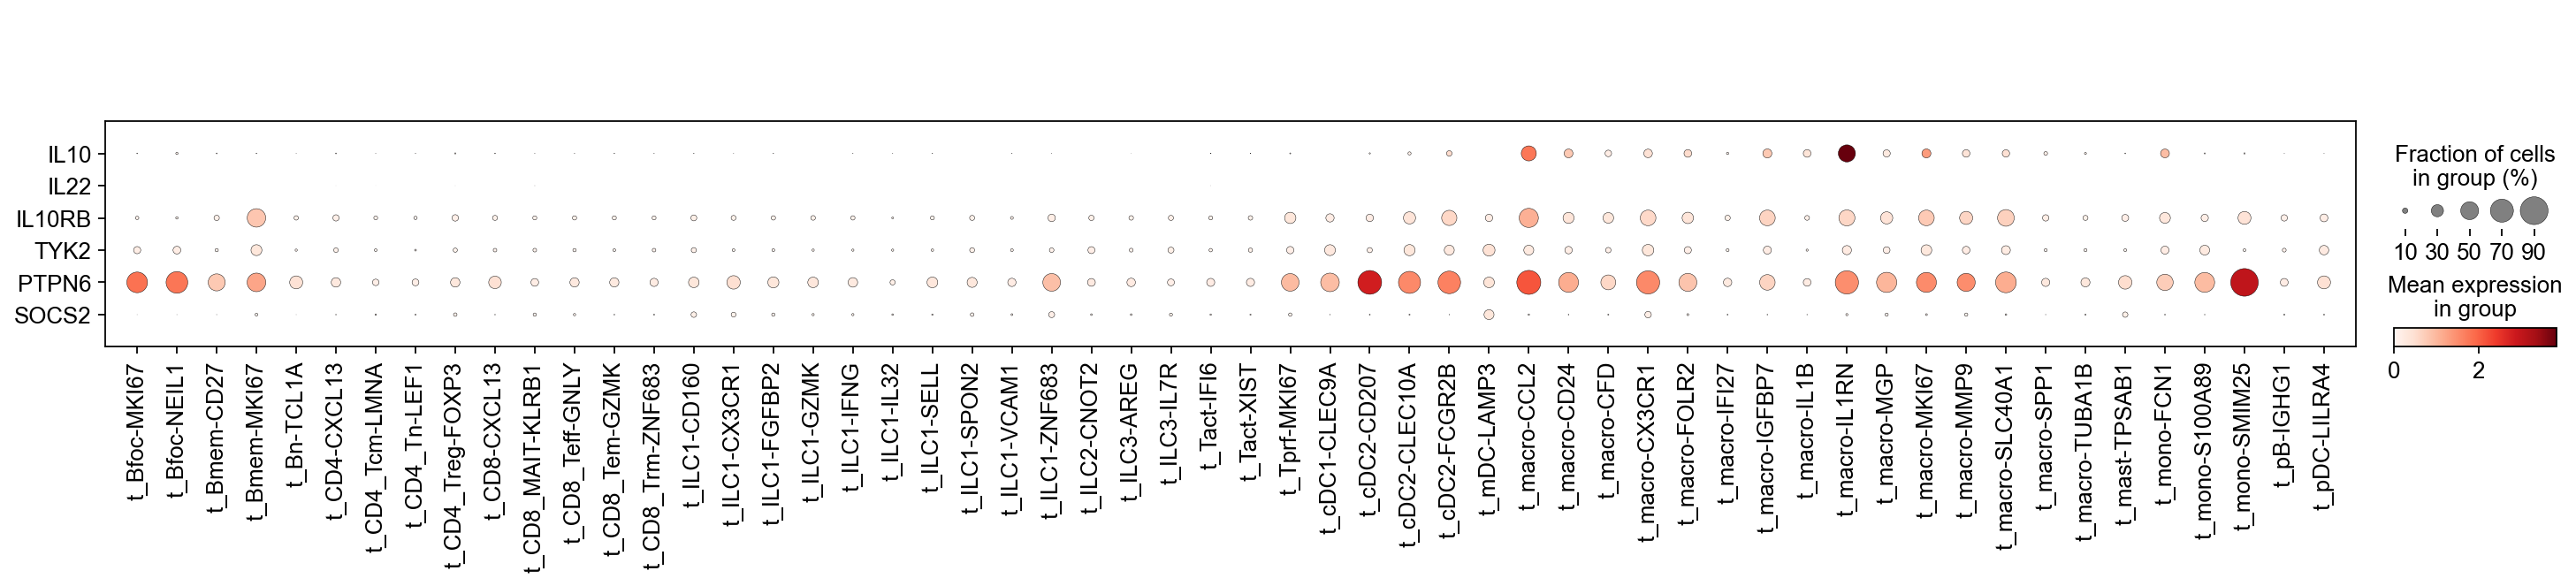

In [227]:
sc.pl.dotplot(adata, ZFX_lig['from'], 'Sub_Cluster',swap_axes=True)

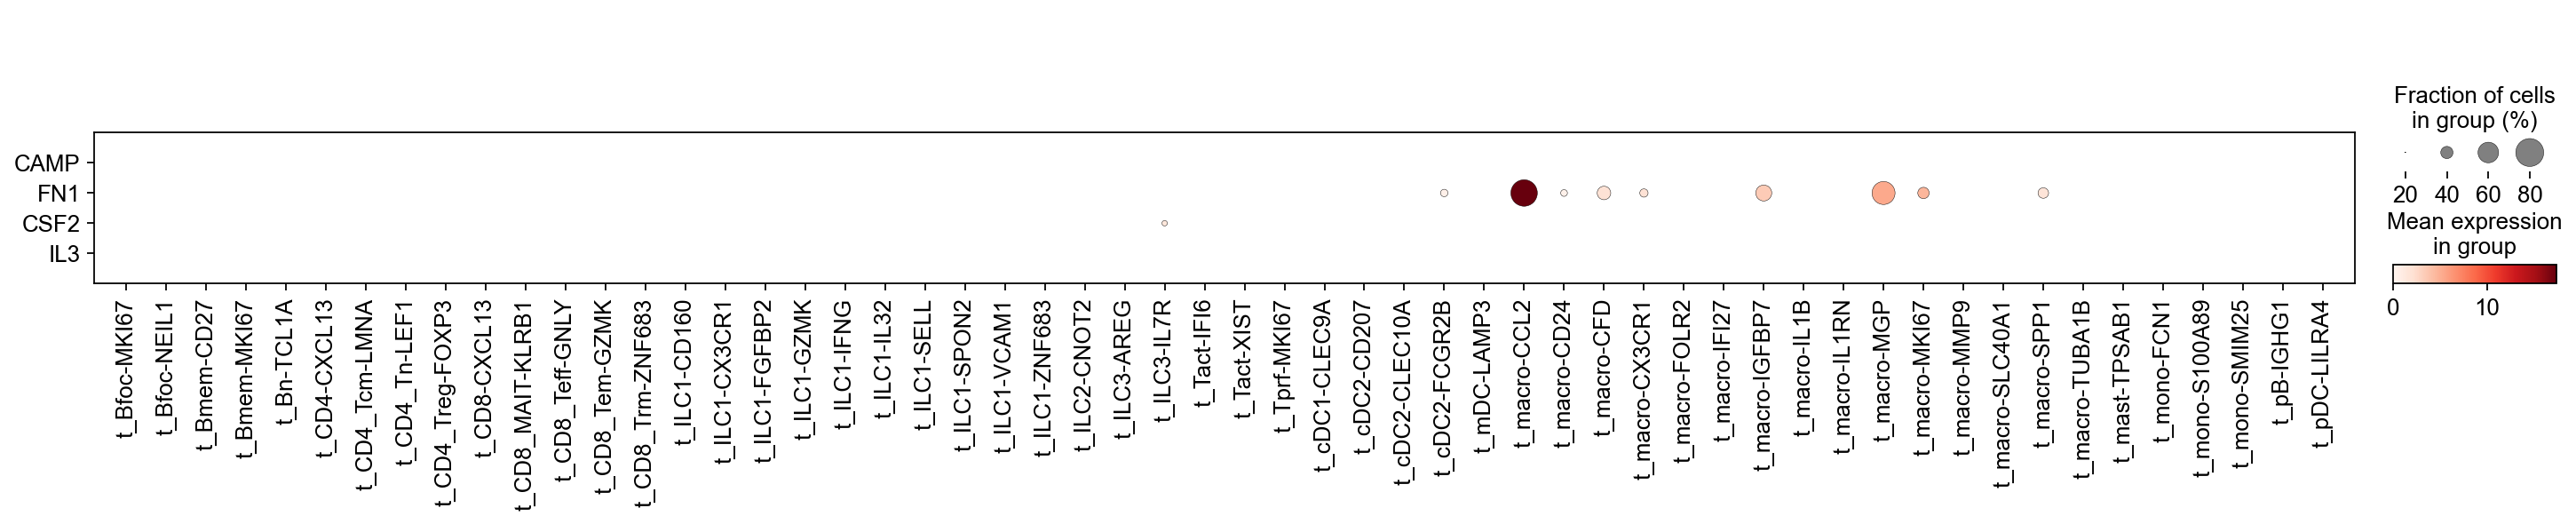

In [109]:
sc.pl.dotplot(adata, MAFF_lig['from'], 'Sub_Cluster',swap_axes=True,dot_min=0.2)